In [1]:
def compare_distributions(df, healthy_status, tissue):
    """
    Compare the distributions of a specific tissue between healthy and diseased samples.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing the data.
        healthy_status (str): Value in 'disease_status' indicating healthy samples.
        tissue (str): Column name of the tissue to compare.
    
    Returns:
        str: Summary of the statistical test results.
    """
    # Filter for healthy and diseased samples
    healthy_samples = df[df['disease_status'] == healthy_status][tissue]
    diseased_samples = df[df['disease_status'] != healthy_status][tissue]
    
    # Check normality
    healthy_normality = shapiro(healthy_samples)
    diseased_normality = shapiro(diseased_samples)
    print(f"Healthy samples normality test: {healthy_normality.statistic:.3f} with p-value {healthy_normality.pvalue:.3f}")
    print(f"Diseased samples normality test: {diseased_normality.statistic:.3f} with p-value {diseased_normality.pvalue:.3f}")
    
    # Choose the appropriate test
    if healthy_normality.pvalue > 0.05 and diseased_normality.pvalue > 0.05:
        # Both distributions are normal; use t-test
        stat, p_value = ttest_ind(healthy_samples, diseased_samples, equal_var=False)
        test_name = "T-Test"
    else:
        # Non-parametric test
        stat, p_value = mannwhitneyu(healthy_samples, diseased_samples)
        test_name = "Mann-Whitney U Test"
    
    # Print results
    significance = "Significant difference" if p_value < 0.05 else "No significant difference"
    print(f"{test_name} Results:")
    print(f"Statistic: {stat:.3f}, P-value: {p_value:.3f}")
    print(significance)
    
    return f"{test_name}: Statistic={stat:.3f}, P-value={p_value:.3f}, {significance}"

In [2]:
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import shapiro
import sys
# sys.modules.pop("mlmarker", None)

import mlmarker
# print(mlmarker.__file__)
# import mlmarker.model as MLMarker
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

import pyteomics
from pyteomics import auxiliary as aux
pd.options.mode.chained_assignment = None

import tqdm
sys.path.append('/home/compomics/git/Projects/MLMarker_paper')
from MLMarker_reprocessing_quant import *

import umap
import sys
sys.setrecursionlimit(10000)
plt.figure(figsize=(20,20))

import dash_bio

import bioservices
from bioservices import UniProt
u = UniProt()

<Figure size 2000x2000 with 0 Axes>

PXD007592: Melanoma cancer samples from cerebral metastasis, progression-free survival classification into good and poor responders to MAP Kinase inhibitor therapy for BRAF mutated melanoma

In [3]:
featureskept = {"poor_responder_12_1.mgf.gzip": 1576,
"poor_responder_8_2.mgf.gzip": 1994,
"poor_responder_7_2.mgf.gzip": 2254,
"good_responder_4_1.mgf.gzip": 886,
"poor_responder_5_2.mgf.gzip": 2400,
"good_responder_2_1.mgf.gzip": 1884,
"poor_responder_13_1.mgf.gzip": 2269,
"poor_responder_6_1.mgf.gzip": 2557,
"poor_responder_11_2.mgf.gzip": 2132,
"poor_responder_1_2.mgf.gzip": 2136,
"poor_responder_9_2.mgf.gzip": 2185,
"good_responder_3_2.mgf.gzip": 2163,
"poor_responder_1_1.mgf.gzip": 2151,
"poor_responder_11_1.mgf.gzip": 2102,
"good_responder_5_1.mgf.gzip": 1354,
"poor_responder_3_1.mgf.gzip": 2550,
"poor_responder_2_2.mgf.gzip": 1905,
"good_responder_2_2.mgf.gzip": 1816,
"poor_responder_2_1.mgf.gzip": 1889,
"poor_responder_10_1.mgf.gzip": 2107,
"poor_responder_3_2.mgf.gzip": 2473,
"poor_responder_13_2.mgf.gzip": 2254,
"poor_responder_4_1.mgf.gzip": 2229,
"good_responder_1_1.mgf.gzip": 473,
"poor_responder_12_2.mgf.gzip": 1618,
"good_responder_1_2.mgf.gzip": 484,
"poor_responder_6_2.mgf.gzip": 2575,
"good_responder_3_1.mgf.gzip": 2178,
"good_responder_4_2.mgf.gzip": 901,
"poor_responder_5_1.mgf.gzip": 2418,
"poor_responder_8_1.mgf.gzip": 2003,
"poor_responder_4_2.mgf.gzip": 2201,
"good_responder_5_2.mgf.gzip": 1386,
"poor_responder_7_1.mgf.gzip": 2293,
"poor_responder_9_1.mgf.gzip": 2163,
"poor_responder_10_2.mgf.gzip": 2182}

In [4]:
df = pd.read_csv('QuantifiedProteins.tsv', sep='\t')
df['gene'] = df['Protein Groups']
df = df[~df['gene'].str.contains('Cont')]
genelist = df['gene'].unique()
genetoprotein = {}
manual_map = []
for g in tqdm.tqdm(genelist):
    # check if u.retrieve returns not a warning
    response = u.retrieve(g)
    if isinstance(response, dict):
        if 'primaryAccession' in response:
            protid = response['primaryAccession']
            genetoprotein[g] = protid
    elif isinstance(response, int):
        manual_map.append(g)
    elif response.get('status_code') == 400 or 'warning' in response.text:
        manual_map.append(g)
        continue
    else:
        manual_map.append(g)
df['protein'] = df['gene'].map(genetoprotein)
df.head()

  0%|          | 1/6642 [00:00<13:02,  8.49it/s]

 83%|████████▎ | 5518/6642 [23:39<04:34,  4.10it/s]WARNING [bioservices.UniProt:596]:  status is not ok with Bad Request
WARNING [bioservices.UniProt:596]:  status is not ok with Bad Request
 83%|████████▎ | 5520/6642 [23:39<04:20,  4.31it/s]WARNING [bioservices.UniProt:596]:  status is not ok with Bad Request
WARNING [bioservices.UniProt:596]:  status is not ok with Bad Request
 83%|████████▎ | 5522/6642 [23:39<04:15,  4.38it/s]WARNING [bioservices.UniProt:596]:  status is not ok with Bad Request
WARNING [bioservices.UniProt:596]:  status is not ok with Bad Request
 83%|████████▎ | 5530/6642 [23:41<04:32,  4.08it/s]WARNING [bioservices.UniProt:596]:  status is not ok with Bad Request
WARNING [bioservices.UniProt:596]:  status is not ok with Bad Request
 83%|████████▎ | 5532/6642 [23:42<04:19,  4.28it/s]WARNING [bioservices.UniProt:596]:  status is not ok with Bad Request
WARNING [bioservices.UniProt:596]:  status is not ok with Bad Request
100%|██████████| 6642/6642 [28:28<00:00,  3.8

,Protein Groups,Gene Name,Organism,Intensity good_responder_1_1,Intensity good_responder_1_2,Intensity good_responder_2_1,Intensity good_responder_2_2,Intensity good_responder_3_1,Intensity good_responder_3_2,Intensity good_responder_4_1,...,Intensity poor_responder_6_1,Intensity poor_responder_6_2,Intensity poor_responder_7_1,Intensity poor_responder_7_2,Intensity poor_responder_8_1,Intensity poor_responder_8_2,Intensity poor_responder_9_1,Intensity poor_responder_9_2,gene,protein
0,1433E_HUMAN,NaN,NaN,3.310385e+07,2.419982e+07,4.259672e+07,3.735999e+07,4.879881e+08,4.983080e+08,2.358096e+07,...,2.511457e+08,2.393805e+08,4.352050e+08,3.424619e+08,2.067065e+08,2.096162e+08,2.669441e+08,2.885599e+08,1433E_HUMAN,P62258
1,1433F_HUMAN,NaN,NaN,1.774740e+06,2.207387e+06,7.425527e+06,5.042727e+06,9.849733e+07,8.432613e+07,5.120667e+06,...,6.349508e+06,1.900698e+07,6.234470e+07,7.083404e+07,3.013392e+07,3.069074e+07,3.804948e+07,3.871897e+07,1433F_HUMAN,Q04917
2,1433G_HUMAN,NaN,NaN,1.095021e+06,2.564823e+06,6.293428e+06,7.343138e+06,9.792576e+07,9.554236e+07,4.496359e+06,...,1.342786e+07,2.271512e+07,7.857671e+07,1.345636e+08,4.760817e+07,4.593734e+07,4.839000e+07,5.499813e+07,1433G_HUMAN,P61981
3,1433S_HUMAN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1433S_HUMAN,P31947
4,1433T_HUMAN,NaN,NaN,0.000000e+00,0.000000e+00,1.976730e+07,1.366726e+07,1.003937e+08,8.751298e+07,1.514065e+07,...,5.974924e+07,5.330161e+07,1.128929e+08,8.556700e+07,4.277093e+07,4.584936e+07,1.147371e+08,7.921284e+07,1433T_HUMAN,P27348


In [5]:
df.head()

,Protein Groups,Gene Name,Organism,Intensity good_responder_1_1,Intensity good_responder_1_2,Intensity good_responder_2_1,Intensity good_responder_2_2,Intensity good_responder_3_1,Intensity good_responder_3_2,Intensity good_responder_4_1,...,Intensity poor_responder_6_1,Intensity poor_responder_6_2,Intensity poor_responder_7_1,Intensity poor_responder_7_2,Intensity poor_responder_8_1,Intensity poor_responder_8_2,Intensity poor_responder_9_1,Intensity poor_responder_9_2,gene,protein
0,1433E_HUMAN,NaN,NaN,3.310385e+07,2.419982e+07,4.259672e+07,3.735999e+07,4.879881e+08,4.983080e+08,2.358096e+07,...,2.511457e+08,2.393805e+08,4.352050e+08,3.424619e+08,2.067065e+08,2.096162e+08,2.669441e+08,2.885599e+08,1433E_HUMAN,P62258
1,1433F_HUMAN,NaN,NaN,1.774740e+06,2.207387e+06,7.425527e+06,5.042727e+06,9.849733e+07,8.432613e+07,5.120667e+06,...,6.349508e+06,1.900698e+07,6.234470e+07,7.083404e+07,3.013392e+07,3.069074e+07,3.804948e+07,3.871897e+07,1433F_HUMAN,Q04917
2,1433G_HUMAN,NaN,NaN,1.095021e+06,2.564823e+06,6.293428e+06,7.343138e+06,9.792576e+07,9.554236e+07,4.496359e+06,...,1.342786e+07,2.271512e+07,7.857671e+07,1.345636e+08,4.760817e+07,4.593734e+07,4.839000e+07,5.499813e+07,1433G_HUMAN,P61981
3,1433S_HUMAN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1433S_HUMAN,P31947
4,1433T_HUMAN,NaN,NaN,0.000000e+00,0.000000e+00,1.976730e+07,1.366726e+07,1.003937e+08,8.751298e+07,1.514065e+07,...,5.974924e+07,5.330161e+07,1.128929e+08,8.556700e+07,4.277093e+07,4.584936e+07,1.147371e+08,7.921284e+07,1433T_HUMAN,P27348


In [6]:
prediction_df = {}
runs = df.columns[3:-2]
for i in runs:
    subset = df[['protein', i]]
    #drop zero values
    subset = subset[subset[i] != 0]
    subset = subset.dropna()
    subset[i] = (subset[i] - subset[i].min()) / (subset[i].max() - subset[i].min())
    test = MLMarker(subset.set_index('protein').T.iloc[0:1], binary=False, dev=True)
    prediction = test.explainability.adjusted_absent_shap_values_df(n_preds=100).sum(axis=1)
    prediction_df[i] = prediction
prediction_df = pd.DataFrame(prediction_df)
prediction_df

,Intensity good_responder_1_1,Intensity good_responder_1_2,Intensity good_responder_2_1,Intensity good_responder_2_2,Intensity good_responder_3_1,Intensity good_responder_3_2,Intensity good_responder_4_1,Intensity good_responder_4_2,Intensity good_responder_5_1,Intensity good_responder_5_2,...,Intensity poor_responder_5_1,Intensity poor_responder_5_2,Intensity poor_responder_6_1,Intensity poor_responder_6_2,Intensity poor_responder_7_1,Intensity poor_responder_7_2,Intensity poor_responder_8_1,Intensity poor_responder_8_2,Intensity poor_responder_9_1,Intensity poor_responder_9_2
tissue,,,,,,,,,,,,,,,,,,,,,
Adipose tissue,0.03220,0.02653,0.00429,0.00464,-0.01277,-0.00541,0.09389,0.08147,-0.01646,-0.01474,...,-0.00936,-0.00985,0.00042,0.00795,-0.01255,-0.01238,-0.01281,-0.00743,-0.00736,-0.00732
Adrenal gland,-0.02208,-0.02810,-0.00051,-0.01106,-0.01548,-0.02227,-0.02128,-0.01842,-0.02431,-0.02222,...,-0.02698,-0.01263,-0.01493,-0.02063,-0.01040,-0.00186,-0.00135,-0.00652,-0.00189,-0.00118
Appendix,0.06551,0.05028,0.01906,0.02450,-0.01326,-0.00920,0.03334,0.03664,-0.01521,-0.01431,...,0.02129,0.01184,0.02072,0.03437,-0.00105,0.00229,-0.01109,-0.01123,0.00144,-0.00619
B-cells,-0.03331,-0.02808,0.04946,0.03935,-0.03398,-0.03391,-0.02362,-0.01809,-0.03901,-0.03895,...,0.00750,0.01804,0.05941,0.04366,-0.02857,-0.02855,-0.03400,-0.02871,-0.02343,-0.02341
Bone marrow,0.09496,0.09679,-0.00505,-0.00284,-0.01534,-0.01535,-0.00681,-0.00262,-0.01313,-0.01331,...,0.00024,-0.00045,0.00017,-0.00261,-0.01103,-0.01091,-0.00985,-0.01415,-0.01426,-0.01431
Brain,-0.01482,-0.01591,0.09264,0.08229,0.74533,0.75552,-0.01485,-0.01298,0.74709,0.71571,...,0.25388,0.25190,0.08918,0.07590,0.47888,0.50308,0.64756,0.67394,0.55038,0.60518
Colon,-0.01818,-0.01913,-0.00557,-0.00069,-0.02839,-0.02531,0.00889,0.00533,-0.02083,-0.02010,...,-0.01552,-0.01265,-0.01253,-0.01318,-0.02123,-0.00883,-0.01508,-0.01515,-0.01750,-0.01709
Duodenum,-0.02785,-0.02833,-0.02981,-0.03270,-0.03263,-0.03255,-0.02822,-0.02399,-0.03136,-0.02914,...,-0.02971,-0.03116,-0.02522,-0.02722,-0.03247,-0.03230,-0.03260,-0.03269,-0.03254,-0.03257
Endometrium,-0.01854,-0.01950,-0.01426,-0.00959,-0.02844,-0.02658,-0.00422,-0.00730,-0.02087,-0.01499,...,-0.01535,-0.00933,-0.00742,-0.01878,-0.01910,-0.01934,-0.02666,-0.02665,-0.02473,-0.02452


In [7]:
mlmarker_df = prediction_df.pivot_table(columns='tissue')
mlmarker_df['filename'] = mlmarker_df.index
mlmarker_df['disease_status'] = mlmarker_df['filename'].apply(lambda x: 'good' if 'good' in x else 'poor')
mlmarker_df.head()

tissue,Adipose tissue,Adrenal gland,Appendix,B-cells,Bone marrow,Brain,Colon,Duodenum,Endometrium,Esophagus,...,Small intestine,Smooth muscle,Spleen,Stomach,Testis,Thyroid,Tonsil,Urinary bladder,filename,disease_status
Intensity good_responder_1_1,0.03220,-0.02208,0.06551,-0.03331,0.09496,-0.01482,-0.01818,-0.02785,-0.01854,-0.00838,...,-0.03458,-0.01884,0.01517,-0.00498,0.02087,-0.01238,-0.03952,-0.01307,Intensity good_responder_1_1,good
Intensity good_responder_1_2,0.02653,-0.02810,0.05028,-0.02808,0.09679,-0.01591,-0.01913,-0.02833,-0.01950,-0.01245,...,-0.03465,-0.01946,0.02471,-0.00635,0.02602,-0.01659,-0.03956,-0.01698,Intensity good_responder_1_2,good
Intensity good_responder_2_1,0.00429,-0.00051,0.01906,0.04946,-0.00505,0.09264,-0.00557,-0.02981,-0.01426,-0.02130,...,-0.03511,-0.01209,0.04938,-0.01936,0.04272,-0.01914,-0.02446,0.00104,Intensity good_responder_2_1,good
Intensity good_responder_2_2,0.00464,-0.01106,0.02450,0.03935,-0.00284,0.08229,-0.00069,-0.03270,-0.00959,-0.01992,...,-0.03520,-0.00285,0.03829,-0.02032,0.04121,-0.01926,-0.02381,-0.01346,Intensity good_responder_2_2,good
Intensity good_responder_3_1,-0.01277,-0.01548,-0.01326,-0.03398,-0.01534,0.74533,-0.02839,-0.03263,-0.02844,-0.02366,...,-0.03532,-0.02960,-0.02737,-0.01832,-0.02614,-0.02826,-0.02999,-0.02710,Intensity good_responder_3_1,good


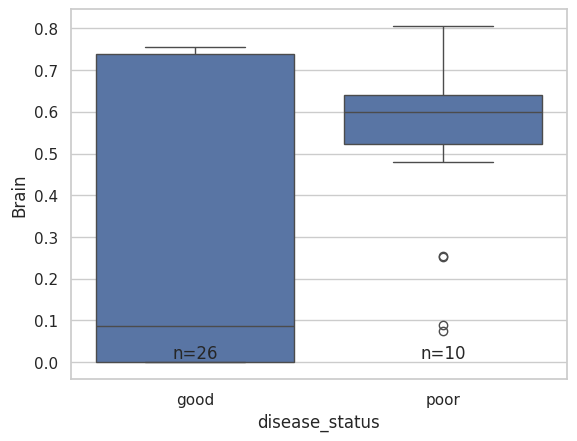

In [8]:
mlmarker_df.iloc[:,:-2] = mlmarker_df.iloc[:,:-2].clip(lower=0)
sns.boxplot(data=mlmarker_df, x='disease_status', y='Brain')
#add the number of samples to the xaxis label
for i in range(2):
    count = mlmarker_df['disease_status'].value_counts().values[i]
    plt.text(i, 0, f"n={count}", ha='center', va='bottom')

In [9]:
compare_distributions(mlmarker_df, 'good', 'Brain')

Healthy samples normality test: 0.701 with p-value 0.001
Diseased samples normality test: 0.813 with p-value 0.000
Mann-Whitney U Test Results:
Statistic: 103.000, P-value: 0.349
No significant difference


'Mann-Whitney U Test: Statistic=103.000, P-value=0.349, No significant difference'

In [10]:
for i in mlmarker_df.columns[1:-3]:
    print(i)
    compare_distributions(mlmarker_df, 'good', i)

Adrenal gland
Healthy samples normality test: 1.000 with p-value 1.000
Diseased samples normality test: 1.000 with p-value 1.000
T-Test Results:
Statistic: nan, P-value: nan
No significant difference
Appendix
Healthy samples normality test: 0.883 with p-value 0.140
Diseased samples normality test: 0.515 with p-value 0.000
Mann-Whitney U Test Results:
Statistic: 187.000, P-value: 0.023
Significant difference
B-cells
Healthy samples normality test: 0.533 with p-value 0.000
Diseased samples normality test: 0.401 with p-value 0.000
Mann-Whitney U Test Results:
Statistic: 137.000, P-value: 0.724
No significant difference
Bone marrow
Healthy samples normality test: 0.512 with p-value 0.000
Diseased samples normality test: 0.309 with p-value 0.000
Mann-Whitney U Test Results:
Statistic: 148.000, P-value: 0.257
No significant difference
Brain
Healthy samples normality test: 0.701 with p-value 0.001
Diseased samples normality test: 0.813 with p-value 0.000
Mann-Whitney U Test Results:
Statistic

/tmp/ipykernel_60131/3988406340.py:18: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  healthy_normality = shapiro(healthy_samples)
/tmp/ipykernel_60131/3988406340.py:19: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  diseased_normality = shapiro(diseased_samples)


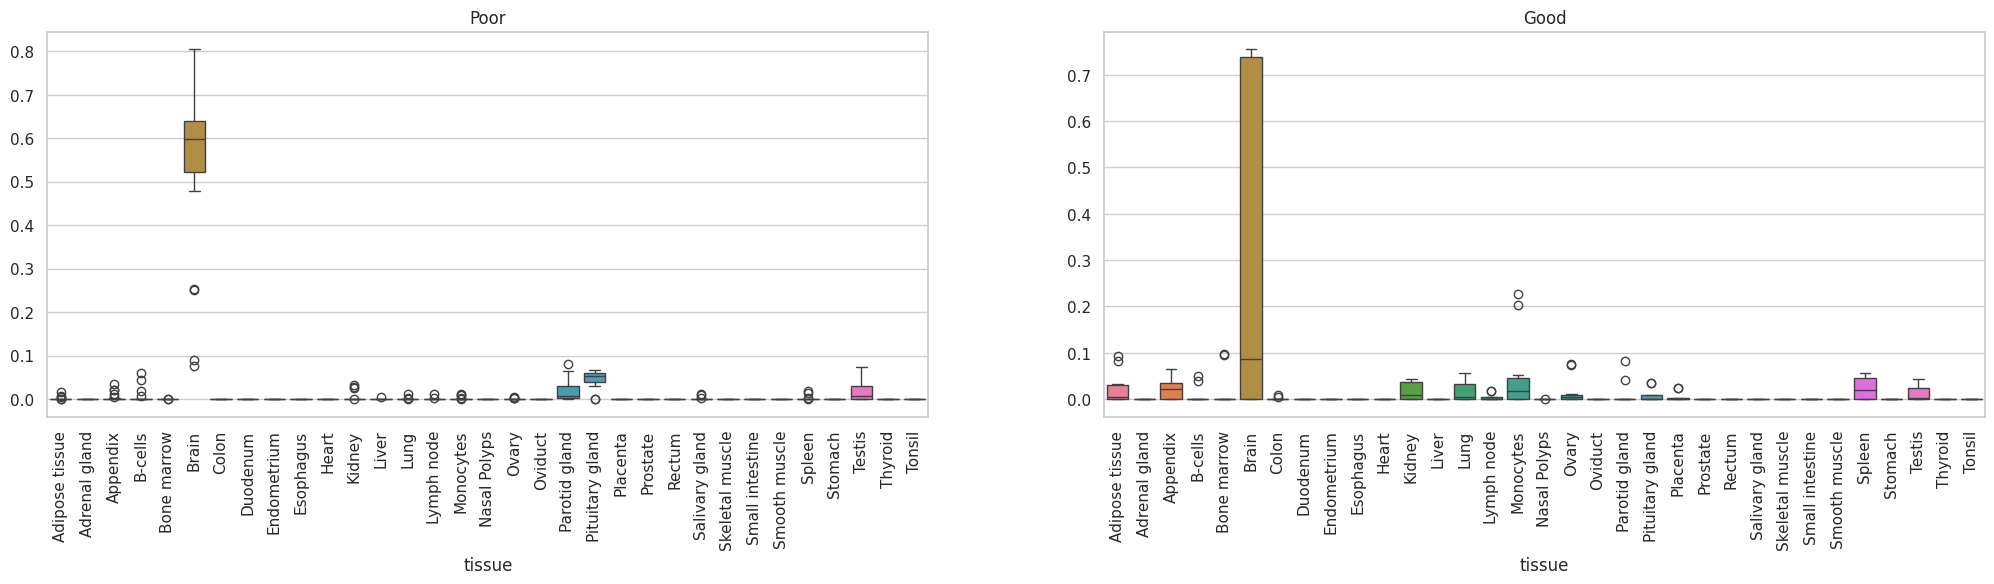

In [11]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(25, 5))
sns.boxplot(data=mlmarker_df[mlmarker_df['disease_status'] == 'poor'].iloc[:,:-3], ax=axs[0])
axs[0].set_title('Poor')
axs[0].tick_params(axis='x', rotation=90)
sns.boxplot(data=mlmarker_df[mlmarker_df['disease_status'] == 'good'].iloc[:,:-3], ax=axs[1])
axs[1].set_title('Good')
axs[1].tick_params(axis='x', rotation=90)
plt.show()

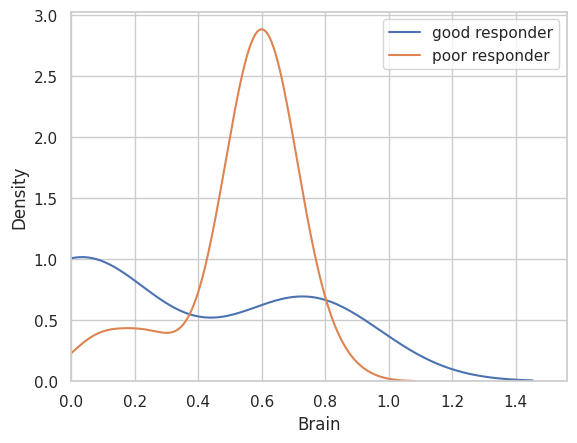

In [12]:
sns.kdeplot(mlmarker_df[mlmarker_df['disease_status'] == 'good']['Brain'], label='good responder')
sns.kdeplot(mlmarker_df[mlmarker_df['disease_status'] == 'poor']['Brain'], label='poor responder')
plt.xlim(-0.001)
plt.legend()


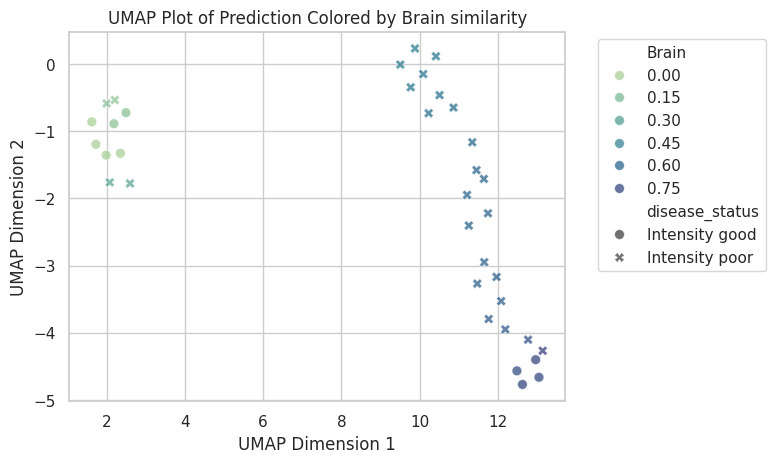

In [13]:
#make a umap 
reducer = umap.UMAP()
x = mlmarker_df.copy().set_index('filename').drop(columns=['disease_status'])
embedding_pred = reducer.fit_transform(x.fillna(0))
embedding_pred_df = pd.DataFrame(embedding_pred)
embedding_pred_df['filename'] = x.index
embedding_pred_df['disease_status'] = embedding_pred_df['filename'].str.split('_').str[0]
embedding_pred_df['Brain'] = x.loc[:, 'Brain'].reset_index()['Brain']

sns.scatterplot(data=embedding_pred_df, x=embedding_pred_df[0], y=embedding_pred_df[1], hue='Brain', style='disease_status', s=50, alpha=0.7, palette='crest')

plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP Plot of Prediction Colored by Brain similarity')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


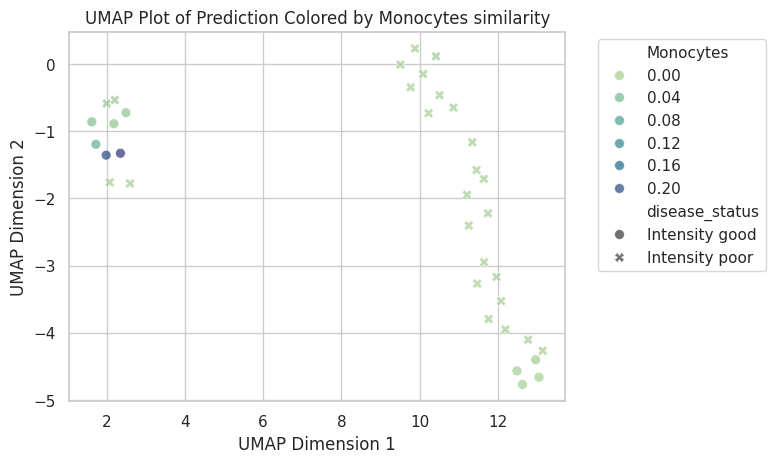

In [14]:
embedding_pred_df['Monocytes'] = x.loc[:, 'Monocytes'].reset_index()['Monocytes']

sns.scatterplot(data=embedding_pred_df, x=embedding_pred_df[0], y=embedding_pred_df[1], hue='Monocytes', style='disease_status', s=50, alpha=0.7, palette='crest')

plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP Plot of Prediction Colored by Monocytes similarity')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


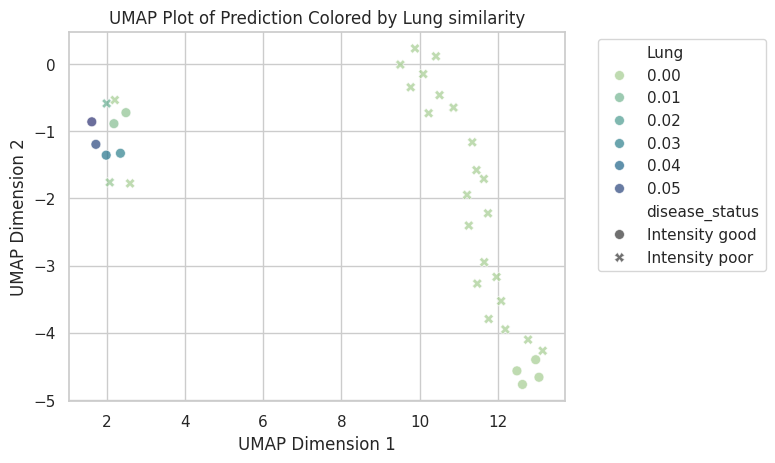

In [15]:
embedding_pred_df['Lung'] = x.loc[:, 'Lung'].reset_index()['Lung']

sns.scatterplot(data=embedding_pred_df, x=embedding_pred_df[0], y=embedding_pred_df[1], hue='Lung', style='disease_status', s=50, alpha=0.7, palette='crest')

plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP Plot of Prediction Colored by Lung similarity')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


### If its not brain that gets predicted its lung or monocytes

In [16]:
poorcounts = mlmarker_df[mlmarker_df['disease_status'] == 'poor'].iloc[:, :-3].idxmax(axis=1).value_counts()
goodcounts = mlmarker_df[mlmarker_df['disease_status'] == 'good'].iloc[:, :-3].idxmax(axis=1).value_counts()

df_counts = pd.DataFrame({'poor': poorcounts, 'good': goodcounts})
df_counts = df_counts.fillna(0).astype(int)
df_counts = df_counts.transpose()
df_counts


,Adipose tissue,Brain,Monocytes
poor,0,26,0
good,2,6,2


In [ ]:
poorcounts = mlmarker_df[mlmarker_df['disease_status'] == 'poor'].iloc[:, :-3].idxmax(axis=1).value_counts()
goodcounts = mlmarker_df[mlmarker_df['disease_status'] == 'good'].iloc[:, :-3].idxmax(axis=1).value_counts()

df_counts = pd.DataFrame({'poor': poorcounts, 'good': goodcounts})
df_counts = df_counts.fillna(0).astype(int)
df_counts = df_counts.transpose()
df_counts


,Brain,Lung,Monocytes
poor,22,4,0
good,4,4,2


In [19]:
largest_column = mlmarker_df.iloc[:, :-3].idxmax(axis=1)
print(largest_column.value_counts())


Brain             32
Monocytes          2
Adipose tissue     2
Name: count, dtype: int64


assign samples to clusters and see which brain specific proteins pop up as most important and how it relates to the original findings

In [18]:
from sklearn.cluster import KMeans

# Assuming `umap_results` is your UMAP embedding (a dataframe or array with columns `umap_1`, `umap_2`)
kmeans = KMeans(n_clusters=2, random_state=42)  # Adjust `n_clusters` based on your UMAP plot
clusters = kmeans.fit_predict(embedding_pred_df[[0, 1]])

# Add clusters to your dataframe
embedding_pred_df['cluster'] = clusters
embedding_pred_df.sort_values(by='Brain')


,0,1,filename,disease_status,Brain,Monocytes,Lung,cluster
0,1.986364,-1.356937,Intensity good_responder_1_1,Intensity good,0.00000,0.20288,0.03441,1
1,2.350631,-1.328343,Intensity good_responder_1_2,Intensity good,0.00000,0.22761,0.03018,1
6,1.618192,-0.860114,Intensity good_responder_4_1,Intensity good,0.00000,0.02842,0.05560,1
7,1.722843,-1.195545,Intensity good_responder_4_2,Intensity good,0.00000,0.05199,0.04936,1
29,2.207556,-0.535428,Intensity poor_responder_6_2,Intensity poor,0.07590,0.00909,0.00047,1
3,2.184163,-0.887784,Intensity good_responder_2_2,Intensity good,0.08229,0.01685,0.00652,1
28,1.998051,-0.587335,Intensity poor_responder_6_1,Intensity poor,0.08918,0.01261,0.01288,1
2,2.491453,-0.723793,Intensity good_responder_2_1,Intensity good,0.09264,0.01717,0.00475,1
27,2.076877,-1.761976,Intensity poor_responder_5_2,Intensity poor,0.25190,0.00087,0.00323,1
26,2.596133,-1.777344,Intensity poor_responder_5_1,Intensity poor,0.25388,0.00000,0.00000,1


In [21]:
#true_poor is if the disease_status is poor and the cluster is 0
poor_brain = embedding_pred_df[(embedding_pred_df['disease_status'] == 'Intensity poor') & (embedding_pred_df['cluster'] == 0)]['filename'].tolist()
#false poor is if the disease_status is poor and the cluster is 1
poor_notbrain = embedding_pred_df[(embedding_pred_df['disease_status'] == 'Intensity poor') & (embedding_pred_df['cluster'] == 1)]['filename'].tolist()
#true_good is if the disease_status is good and the cluster is 1
good_notbrain = embedding_pred_df[(embedding_pred_df['disease_status'] == 'Intensity good') & (embedding_pred_df['cluster'] == 1)]['filename'].tolist()
#false good is if the disease_status is good and the cluster is 0
good_brain = embedding_pred_df[(embedding_pred_df['disease_status'] == 'Intensity good') & (embedding_pred_df['cluster'] == 0)]['filename'].tolist()

print(f"Poor not brain: {poor_notbrain}")
print(f"Good not brain: {good_notbrain}")
print(f"Poor brain: {poor_brain}")
print(f"Good brain: {good_brain}")


Poor not brain: ['Intensity poor_responder_5_1', 'Intensity poor_responder_5_2', 'Intensity poor_responder_6_1', 'Intensity poor_responder_6_2']
Good not brain: ['Intensity good_responder_1_1', 'Intensity good_responder_1_2', 'Intensity good_responder_2_1', 'Intensity good_responder_2_2', 'Intensity good_responder_4_1', 'Intensity good_responder_4_2']
Poor brain: ['Intensity poor_responder_10_1', 'Intensity poor_responder_10_2', 'Intensity poor_responder_11_1', 'Intensity poor_responder_11_2', 'Intensity poor_responder_12_1', 'Intensity poor_responder_12_2', 'Intensity poor_responder_13_1', 'Intensity poor_responder_13_2', 'Intensity poor_responder_1_1', 'Intensity poor_responder_1_2', 'Intensity poor_responder_2_1', 'Intensity poor_responder_2_2', 'Intensity poor_responder_3_1', 'Intensity poor_responder_3_2', 'Intensity poor_responder_4_1', 'Intensity poor_responder_4_2', 'Intensity poor_responder_7_1', 'Intensity poor_responder_7_2', 'Intensity poor_responder_8_1', 'Intensity poor_r

In [22]:
embedding_pred_df[['cluster', 'disease_status']].value_counts()

cluster  disease_status
0        Intensity poor    22
1        Intensity good     6
0        Intensity good     4
1        Intensity poor     4
Name: count, dtype: int64

Paer states: """We detected an EMT feature (up-regulation of N-cadherin) as classifier between the two groups, V-type proton ATPases, cell adhesion proteins and several transporter and exchanger proteins to be significantly up-regulated in poor responding patients, whereas good responders showed an immune activation, among other features. We identified class-discriminating proteins based on nearest shrunken centroids, validated and quantified this signature by a targeted approach and could correlate parts of this signature with resistance using the CPL/MUW proteome database and survival of patients by TCGA analysis. We further validated an EMT-like signature as a major discriminator between good and poor responders on primary melanoma cells derived from cerebral metastases. Higher immune activity is demonstrated in patients with good response to MAPKi by immunohistochemical staining of biopsy samples of cerebral melanoma metastases."""

# Protein level info

In [6]:
def get_go_enrichment(protein_list):
    from gprofiler import GProfiler
    import plotly.graph_objects as go
    # Initialize g:Profiler
    gp = GProfiler(return_dataframe=True)

    # Dictionary to store GO terms and p-values for each tissue
    go_dict = {}


    # Perform GO enrichment
    results = gp.profile(organism='hsapiens', query=protein_list, sources=['GO:BP', 'GO:MF', 'GO:CC', 'HPA'])
    results = results[results['p_value']< 0.05]
    # Store results in the dictionary: {tissue: {GO_term: p-value}}
    return results

In [19]:
pxd = "PXD007592"
base_path = f"/home/compomics/conode*/PRIDE_DATA"  
lengths_path = "/home/compomics/git/Projects/MLMarker_paper/uniprot_reviewed_lengths.tsv"
prot_mlmarker_df, unique_protein_dict = get_mlmarker_dataframe(pxd, base_path, lengths_path, dev=True, tissue_level=False)
prot_mlmarker_df['disease_status'] = prot_mlmarker_df['filename'].str.split('_').str[0]
prot_mlmarker_df = prot_mlmarker_df.reset_index().merge(embedding_pred_df[['filename', 'cluster']], on='filename', how='left')
prot_mlmarker_df.head()

,index,Brain,Kidney,Testis,Pituitary gland,Lung,Adrenal gland,Colon,Monocytes,Thyroid,...,Salivary gland,Nasal Polyps,Tonsil,B-cells,Small intestine,Parotid gland,PXD_folder,filename,disease_status,cluster
0,A0A075B6H7,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.0,0.00000,0.0,0.0,0.0,0.00000,PXD007592,poor_responder_12_1.mgf.gzip,poor,0
1,A0A075B6H8,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.0,0.00000,0.0,0.0,0.0,0.00000,PXD007592,poor_responder_12_1.mgf.gzip,poor,0
2,A0A075B6H9,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.0,0.00000,-0.0,0.0,0.0,0.00000,PXD007592,poor_responder_12_1.mgf.gzip,poor,0
3,A0A075B6I0,0.00015,0.00002,0.00002,0.00001,0.00002,0.00001,-0.00011,0.00002,0.00001,...,0.0,-0.00028,0.0,0.0,0.0,0.00002,PXD007592,poor_responder_12_1.mgf.gzip,poor,0
4,A0A075B6I9,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.0,0.00000,0.0,0.0,0.0,0.00000,PXD007592,poor_responder_12_1.mgf.gzip,poor,0


In [20]:
unique_mlmarker_proteins = set(prot_mlmarker_df['index'].unique())
len(unique_mlmarker_proteins)   
unique_protein_values = list(set(sum(unique_protein_dict.values(), [])))
prot_mlmarker_df_filtered = prot_mlmarker_df[prot_mlmarker_df['index'].isin(unique_protein_values)]
print(prot_mlmarker_df.shape, prot_mlmarker_df_filtered.shape)

(215244, 39) (164880, 39)


Good responders have a lower brain prediction and often a high monocytes prediction. Which proteins are this?

In [21]:
melted_df = prot_mlmarker_df_filtered[(prot_mlmarker_df_filtered['filename'].isin(poor_brain))].melt(id_vars='index', value_vars=prot_mlmarker_df_filtered.columns[1:-4], var_name='Protein', value_name='Value')
melted_df


,index,Protein,Value
0,A0A075B6H7,Brain,0.00000
1,A0A075B6H8,Brain,0.00000
2,A0A075B6I0,Brain,0.00015
3,A0A075B6K2,Brain,0.00000
4,A0A075B6K4,Brain,0.00000
...,...,...,...
3114395,Q9Y6W5,Parotid gland,0.00000
3114396,Q9Y6X5,Parotid gland,0.00000
3114397,Q9Y6X9,Parotid gland,0.00000
3114398,Q9Y6Y0,Parotid gland,0.00000


In [44]:
monocyte_lung_list = list(set(prot_mlmarker_df_filtered[(prot_mlmarker_df_filtered['filename'].isin(good_notbrain)) & ((prot_mlmarker_df_filtered['Monocytes'] > 0.001) | (prot_mlmarker_df_filtered['Lung'] > 0.001))][['index', 'Monocytes', 'Lung', 'filename']]['index'].tolist()))
len(set(monocyte_lung_list))

brain_list = list(set(prot_mlmarker_df_filtered[(prot_mlmarker_df_filtered['filename'].isin(good_notbrain)) & ((prot_mlmarker_df_filtered['Brain'] > 0.001))][['index', 'Brain', 'filename']]['index'].tolist()))
print(len(brain_list))


highest_shap_values = list(set(prot_mlmarker_df_filtered[(prot_mlmarker_df_filtered['filename'].isin(good_notbrain)) & ((prot_mlmarker_df_filtered['Brain'] > 0.001))][['index', 'Brain', 'filename']]['index'].tolist()))

10


In [14]:
def get_go_enrichment(protein_list):

    # Initialize g:Profiler
    gp = GProfiler(return_dataframe=True)

    # Dictionary to store GO terms and p-values for each tissue
    go_dict = {}


    # Perform GO enrichment
    results = gp.profile(organism='hsapiens', query=protein_list, sources=['GO:BP', 'GO:MF', 'GO:CC', 'HPA'])
    #p_values contains a list of floats, get the first element
    results = results[results['p_value']< 0.01]
    # Store results in the dictionary: {tissue: {GO_term: p-value}}
    return results
from plotly.subplots import make_subplots
from gprofiler import GProfiler
import plotly.graph_objects as go
def visualise_go_enrichment(df):
    # Add a -log10(p-value) column for better visualization of significance
    df['-log10(p_value)'] = -np.log10(df['p_value'])

    # Sort the data by -log10(p_value) for ranking from high to low
    df_sorted = df.sort_values(by="-log10(p_value)", ascending=False)

    # Create the plot (vertical line for each term)
    fig = px.bar(
        df_sorted,
        x="-log10(p_value)",  # x-axis as -log10(p-value)
        y="name",  # Each term will be on a separate line on the y-axis
        color="source",  # Color by source (optional)
        orientation='h',  # Horizontal bars to simulate vertical lines
        hover_name="name",
        labels={"-log10(p_value)": "-log10(p-value)", "name": "Gene Ontology Term"},
        title="GO Enrichment Term Rank"
    )

    # Update layout
    fig.update_traces(marker=dict(opacity=0.8, line=dict(width=1, color='DarkSlateGrey')))
    fig.update_layout(
        template="plotly_white",
        title_x=0.5,
        xaxis_title="-log10(p-value)",
        yaxis_title="GO Terms",
        height=1500,
        width=1200
    )

    fig.show()


def visualise_go_enrichment(df,  title, proteins, max_bars=20,):
    # Add a -log10(p-value) column for better visualization of significance
    df['-log10(p_value)'] = -np.log10(df['p_value'])

    # Sort the data by -log10(p_value) for ranking from high to low
    df_sorted = df.sort_values(by="-log10(p_value)", ascending=False)

    # Get the unique source types (e.g., 'GO:CC', 'GO:BP', 'HPA')
    sources = sorted(df_sorted['source'].unique())
    max_log_p_value = df_sorted['-log10(p_value)'].max()
    # Create subplots: 2 rows and 2 columns
    fig = make_subplots(
        rows=1, cols=4,  # 1 row, 4 columns
        subplot_titles=sources,  # Titles for each subplot (based on source)
        shared_yaxes=False  # Share y-axis to make comparison easier
    )

    # Loop over each source and add a bar trace
    for i, source in enumerate(sources, start=1):
        source_df = df_sorted[df_sorted['source'] == source]
        source_df = source_df.head(max_bars)
        # Create the bar trace for this source
        trace = go.Bar(
            x=source_df['-log10(p_value)'],
            y=source_df['name'],
            orientation='h',
            name=source,
            hoverinfo='x+y',
            marker=dict(opacity=0.8, line=dict(width=1, color='DarkSlateGrey'))
        )
        
        # Add the trace to the corresponding subplot
        fig.add_trace(trace, row=1, col=i)

    # Update layout
    fig.update_layout(
        template="plotly_white",
        title=f"{title} GO Enrichment Term Rank (Max 20 bars) for {proteins} proteins",
        title_x=0.5,
        xaxis_title="-log10(p-value)",
        yaxis_title="GO Terms",
        height=600,
        width=3000,
        showlegend=False,
        xaxis=dict(range=[0, max_log_p_value]),  # Set the same range for all subplots
        xaxis2=dict(range=[0, max_log_p_value]),
        xaxis3=dict(range=[0, max_log_p_value]),
        xaxis4=dict(range=[0, max_log_p_value]),
    )
    # Show the plot
    fig.show()

In [ ]:
samples = [poor_brain, poor_notbrain, good_notbrain, good_brain]
sample_names = ['Poor brain', 'Poor not brain', 'Good not brain', 'Good brain']
sample_protdict = {}
for i, sample in enumerate(samples):
    print(sample_names[i])
    # Calculate the top quartile threshold
    top_quartile_threshold = np.percentile(prot_mlmarker_df_filtered['index'], 75)
    # Select the proteins in the top quartile
    top_quartile_index = list(set(prot_mlmarker_df_filtered[(prot_mlmarker_df_filtered['filename'].isin(sample)) & (prot_mlmarker_df_filtered['index'] >= top_quartile_threshold)].set_index('index').iloc[:,:-4].index))
    print(len(top_quartile_index))
    sample_protdict[sample_names[i]] = top_quartile_index
    godf = get_go_enrichment(top_quartile_index)
    visualise_go_enrichment(godf, title=sample_names[i], max_bars=20, proteins=len(top_quartile_index))

In [68]:
averaged_df[averaged_df.apply(lambda row: any(row > top_percentile_threshold), axis=1)]


,Brain,Kidney,Testis,Pituitary gland,Lung,Adrenal gland,Colon,Monocytes,Thyroid,Adipose tissue,...,Rectum,Placenta,Duodenum,Oviduct,Salivary gland,Nasal Polyps,Tonsil,B-cells,Small intestine,Parotid gland
index,,,,,,,,,,,,,,,,,,,,,
P20916,0.090217,-0.003986,-0.004621,-0.003087,-0.0054,-0.003732,-0.004825,-0.002448,-0.002892,-0.00319,...,-0.002459,-0.002357,-0.001465,-0.001937,-0.002187,-0.000759,-0.000766,-0.001368,-0.001361,-0.00047


In [74]:
samples = [poor_brain, poor_notbrain, good_notbrain, good_brain]
sample_names = ['Poor brain', 'Poor not brain', 'Good not brain', 'Good brain']
sample_protdict = {}

for i, sample in enumerate(samples):
    print(f"Processing sample: {sample_names[i]}")
    print(f"Sample content: {sample}")
    
    # Filter and average the DataFrame for the current sample
    averaged_df = prot_mlmarker_df_filtered[prot_mlmarker_df_filtered['filename'].isin(sample)].iloc[:, :-4].groupby('index').mean()
    print(averaged_df.shape)
    # Flatten the DataFrame and filter out zero values
    non_zero_values = averaged_df.values.flatten()
    non_zero_values = non_zero_values[non_zero_values != 0]
    
    # Calculate the 95th percentile for the non-zero values
    top_percentile_threshold = pd.Series(non_zero_values).quantile(0.99)
    print(f"95th percentile threshold for {sample_names[i]}: {top_percentile_threshold}")
    
    # Identify the indices where any column contains a value in the top 5%
    top_percentile_indices = list(averaged_df[averaged_df.apply(lambda row: any(row > top_percentile_threshold), axis=1)].index)
    print(f"Number of top percentile indices for {sample_names[i]}: {len(top_percentile_indices)}")
    
    # Store the indices in the dictionary
    sample_protdict[sample_names[i]] = top_percentile_indices
    
    # Perform GO enrichment and visualization
    godf = get_go_enrichment(top_percentile_indices)
    visualise_go_enrichment(godf, title=sample_names[i], max_bars=20, proteins=len(top_percentile_indices))

Processing sample: Poor brain
Sample content: ['poor_responder_12_1.mgf.gzip', 'poor_responder_8_2.mgf.gzip', 'poor_responder_7_2.mgf.gzip', 'poor_responder_13_1.mgf.gzip', 'poor_responder_11_2.mgf.gzip', 'poor_responder_1_2.mgf.gzip', 'poor_responder_9_2.mgf.gzip', 'poor_responder_1_1.mgf.gzip', 'poor_responder_11_1.mgf.gzip', 'poor_responder_3_1.mgf.gzip', 'poor_responder_2_2.mgf.gzip', 'poor_responder_2_1.mgf.gzip', 'poor_responder_10_1.mgf.gzip', 'poor_responder_3_2.mgf.gzip', 'poor_responder_13_2.mgf.gzip', 'poor_responder_12_2.mgf.gzip', 'poor_responder_8_1.mgf.gzip', 'poor_responder_7_1.mgf.gzip', 'poor_responder_9_1.mgf.gzip', 'poor_responder_10_2.mgf.gzip']
(4580, 34)
95th percentile threshold for Poor brain: 0.00036577500000000514


Number of top percentile indices for Poor brain: 201


Processing sample: Poor not brain
Sample content: ['poor_responder_5_2.mgf.gzip', 'poor_responder_6_1.mgf.gzip', 'poor_responder_4_1.mgf.gzip', 'poor_responder_6_2.mgf.gzip', 'poor_responder_5_1.mgf.gzip', 'poor_responder_4_2.mgf.gzip']
(4580, 34)
95th percentile threshold for Poor not brain: 0.0004121666666666715
Number of top percentile indices for Poor not brain: 145


Processing sample: Good not brain
Sample content: ['good_responder_4_1.mgf.gzip', 'good_responder_2_1.mgf.gzip', 'good_responder_2_2.mgf.gzip', 'good_responder_1_1.mgf.gzip', 'good_responder_1_2.mgf.gzip', 'good_responder_4_2.mgf.gzip']
(4580, 34)
95th percentile threshold for Good not brain: 0.0003770666666666633
Number of top percentile indices for Good not brain: 129


Processing sample: Good brain
Sample content: ['good_responder_3_2.mgf.gzip', 'good_responder_5_1.mgf.gzip', 'good_responder_3_1.mgf.gzip', 'good_responder_5_2.mgf.gzip']
(4580, 34)
95th percentile threshold for Good brain: 0.0003863500000000022
Number of top percentile indices for Good brain: 183


In [48]:
protein_info_list=[]
for i in top_100_index:
    protein_info = get_protein_info(i)
    if protein_info is not None:
        protein_info_list.append(protein_info)

df = pd.DataFrame(protein_info_list)
df

,id,entry name,protein_names,tissue_specificity
0,Q9NZN4,EHD2_HUMAN,EH domain-containing protein 2 (PAST homolog 2),TISSUE SPECIFICITY: Highly expressed in heart ...
1,P50395,GDIB_HUMAN,Rab GDP dissociation inhibitor beta (Rab GDI b...,TISSUE SPECIFICITY: Ubiquitous. {ECO:0000269|P...
2,Q8N5V2,NGEF_HUMAN,Ephexin-1 (Eph-interacting exchange protein) (...,TISSUE SPECIFICITY: Highly expressed in brain ...
3,Q6ZN66,GBP6_HUMAN,Guanylate-binding protein 6 (EC 3.6.5.-) (GTP-...,NaN
4,Q5TH69,BIG3_HUMAN,Brefeldin A-inhibited guanine nucleotide-excha...,TISSUE SPECIFICITY: Expressed in breast cancer...
...,...,...,...,...
377,O00763,ACACB_HUMAN,Acetyl-CoA carboxylase 2 (EC 6.4.1.2) (ACC-beta),TISSUE SPECIFICITY: Widely expressed with high...
378,Q9H2X9,S12A5_HUMAN,Solute carrier family 12 member 5 (Electroneut...,TISSUE SPECIFICITY: Brain specific. Detected i...
379,P35555,FBN1_HUMAN,Fibrillin-1 [Cleaved into: Asprosin],NaN
380,P00488,F13A_HUMAN,Coagulation factor XIII A chain (Coagulation f...,NaN


# Make your own forceplot

In [75]:
samples = [true_good, true_poor, false_good, false_poor]
samples

NameError: name 'true_good' is not defined

In [ ]:
pxd = "PXD007592"
base_path = f"/home/compomics/conode*/PRIDE_DATA"  
lengths_path = "/home/compomics/git/Projects/MLMarker_paper/uniprot_reviewed_lengths.tsv"
prot_mlmarker_df, unique_protein_dict = get_mlmarker_dataframe(pxd, base_path, lengths_path, dev=True, tissue_level=False)
prot_mlmarker_df['disease_status'] = prot_mlmarker_df['filename'].str.split('_').str[0]
prot_mlmarker_df = prot_mlmarker_df.reset_index().merge(embedding_pred_df[['filename', 'cluster']], on='filename', how='left')
prot_mlmarker_df.head()

In [193]:
path = "/home/compomics/conode53_pride/PRIDE_DATA/PXD007592/IONBOT_v0.11.0/good_responder_1_2.mgf.gzip/ionbot.first.csv"
lengths_path = "/home/compomics/git/Projects/MLMarker_paper/uniprot_reviewed_lengths.tsv"
poor_sample = pd.read_csv(path)
lenghts_df = pd.read_csv(lengths_path, sep='\t')
poor_sample_df = ionbot_first_to_prot_quant(poor_sample, lenghts_df)
data = poor_sample_df.pivot_table(columns='proteins', values='NSAF', aggfunc='sum')
data = data.fillna(0)
test = MLMarker(data.iloc[0:1, :], binary=False, dev=True, penalty_factor=0)
prediction = test.explainability.adjusted_absent_shap_values_df( n_preds=100)
#drop columns with all zeroes
prediction = prediction.loc[:, (prediction != 0).any(axis=0)]

In [ ]:
unique_mlmarker_proteins = set(prot_mlmarker_df['index'].unique())
len(unique_mlmarker_proteins)   
unique_protein_values = list(set(sum(unique_protein_dict.values(), [])))
prot_mlmarker_df_filtered = prot_mlmarker_df[prot_mlmarker_df['index'].isin(unique_protein_values)]
print(prot_mlmarker_df.shape, prot_mlmarker_df_filtered.shape)

In [63]:
protein_data = [get_protein_info(protein) for protein in ['P02775']]
protein_df = pd.DataFrame(protein_data)
protein_df


,id,entry name,protein_names
0,P02775,CXCL7_HUMAN,Platelet basic protein (PBP) (C-X-C motif chem...


In [66]:
from plotly.subplots import make_subplots
def visualise_custom_plot(df):
        
    # Aggregate positive and negative contributions per tissue
    positive_totals = df.clip(lower=0).sum(axis=1)
    negative_totals = df.clip(upper=0).abs().sum(axis=1)

    # Create the figure
    fig = go.Figure()

    # Add positive contributions (green bars)
    fig.add_trace(
        go.Bar(
            x=df.index,
            y=positive_totals,
            name="Positive Contributions",
            marker_color='green',
            hoverinfo='x+y',
        )
    )

    # Add negative contributions (red bars)
    fig.add_trace(
        go.Bar(
            x=df.index,
            y=negative_totals,
            name="Negative Contributions",
            marker_color='red',
            hoverinfo='x+y',
        )
    )

    # Customizing layout
    fig.update_layout(
        barmode='group',  # Group positive and negative bars side-by-side
        title='Grouped Barplot of Total Protein Contributions by Tissue',
        xaxis_title='Tissues',
        yaxis_title='Total Contributions',
        xaxis=dict(tickangle=-45),  # Tilt the x-axis labels for better readability
        template="plotly_white"
    )

    fig.show()

def visualise_custom_tissue_plot(df,tissue_name):
    df = df.loc[[tissue_name]]

    # Separate positive and negative values for the tissue
    positive_contributions = df.clip(lower=0)  # Keep only positive values
    negative_contributions = df.clip(upper=0).abs()  # Keep absolute values of negatives

    # Threshold for filtering
    threshold = 0.001

    # Filter significant contributions
    positive_main = positive_contributions.loc[:, (positive_contributions > threshold).any()]
    positive_others = positive_contributions.loc[:, (positive_contributions <= threshold).all()].sum(axis=1)

    negative_main = negative_contributions.loc[:, (negative_contributions > threshold).any()]
    negative_others = negative_contributions.loc[:, (negative_contributions <= threshold).all()].sum(axis=1)


    # Retrieve protein information and values
    protein_data = []
    for protein in positive_main.columns.union(negative_main.columns):
        protein_info = get_protein_info(protein)
        value = positive_main.get(protein, pd.Series(0)).sum() - negative_main.get(protein, pd.Series(0)).sum()
        protein_info['value'] = value
        protein_data.append(protein_info)
    
    protein_df = pd.DataFrame(protein_data)


    # Create a subplot figure
    fig = make_subplots(
        rows=1, cols=2,
        column_widths=[0.4, 0.6],
        subplot_titles=(f"Protein Contributions for {tissue_name}", "Protein Info"),
        specs=[[{"type": "bar"}, {"type": "table"}]]
    )

    # Add positive contributions (green bars)
    for protein in positive_main.columns:
        fig.add_trace(
            go.Bar(
                x=positive_contributions.index,
                y=positive_main[protein],
                name=protein,
                marker_color="green",
                hoverinfo="name+y",
                hoverlabel=dict(namelength=-1),
                showlegend=False,
            ), row=1, col=1
        )

    # Add "Others" for positive contributions
    if positive_others.sum() > 0:
        fig.add_trace(
            go.Bar(
                x=positive_contributions.index,
                y=positive_others,
                name="Others (Positive)",
                marker_color="lightgreen",
                hoverinfo="name+y",
                hoverlabel=dict(namelength=-1),
                showlegend=False,
            ), row=1, col=1
        )

    # Add negative contributions (red bars)
    for protein in negative_main.columns:
        fig.add_trace(
            go.Bar(
                x=negative_contributions.index,
                y=negative_main[protein],
                name=protein,
                marker_color="red",
                hoverinfo="name+y",
                hoverlabel=dict(namelength=-1),
                showlegend=False,
            ), row=1, col=1
        )

    # Add "Others" for negative contributions
    if negative_others.sum() > 0:
        fig.add_trace(
            go.Bar(
                x=negative_contributions.index,
                y=negative_others,
                name="Others (Negative)",
                marker_color="lightcoral",
                hoverinfo="name+y",
                hoverlabel=dict(namelength=-1),
                showlegend=False,
            ), row=1, col=1
        )

    # Add the table with protein info
    fig.add_trace(
        go.Table(
            header=dict(values=["Protein ID", "Value", "Protein Name"], fill_color="lightgrey", align="left"),
            cells=dict(
                values=[protein_df['id'], protein_df['value'], protein_df['protein_names']],
                fill_color="white",
                align="left"
            )
        ),
        row=1, col=2
    )
    # Customizing layout
    fig.update_layout(
        barmode="stack",  # Stack the bars
        title=f"""Protein Contributions for<br> 
        {tissue_name}""",
        xaxis_title="Tissue",
        yaxis_title="Protein Contributions",
        xaxis={"categoryorder": "total descending"},
        hovermode="closest", 
        template="plotly_white",
        width=1200,
        height=600
    )

    fig.show()

In [67]:
samples = [poor_brain, poor_notbrain, good_brain, good_notbrain]

for i_list in samples:
    i = i_list[0]
    path = f"/home/compomics/conode53_pride/PRIDE_DATA/PXD007592/IONBOT_v0.11.0/{i}/ionbot.first.csv"
    lengths_path = "/home/compomics/git/Projects/MLMarker_paper/uniprot_reviewed_lengths.tsv"
    poor_sample = pd.read_csv(path)
    lenghts_df = pd.read_csv(lengths_path, sep='\t')
    poor_sample_df = ionbot_first_to_prot_quant(poor_sample, lenghts_df)
    data = poor_sample_df.pivot_table(columns='proteins', values='NSAF', aggfunc='sum')
    data = data.fillna(0)
    test = MLMarker(data.iloc[0:1, :], binary=False, dev=True, penalty_factor=0)
    prediction = test.explainability.adjusted_absent_shap_values_df( n_preds=100)
    #drop columns with all zeroes
    prediction = prediction.loc[:, (prediction != 0).any(axis=0)]
    most_likely_tissue = prediction.sum(axis=1).sort_values().index[-1]
    # mlmarker.explainability.visualise_custom_plot(df=prediction)
    # mlmarker.explainability.visualise_custom_tissue_plot(prediction, most_likely_tissue)
    visualise_custom_tissue_plot(prediction, most_likely_tissue)

# Discrimintating btw cancer types

In [454]:
original_discriminating_proteins = ["P21266", "P61962", "P62937", "Q16864", "Q6FI81", "Q6UWP2", "Q7Z7E8", "Q8IVD9", "Q8N4Q0"]
print(len(original_discriminating_proteins))
#Cadh2: P19022: N-cadherin, related to poor response
#E-cadherin: Q90Z37 good response
cadherin_proteins = []

9


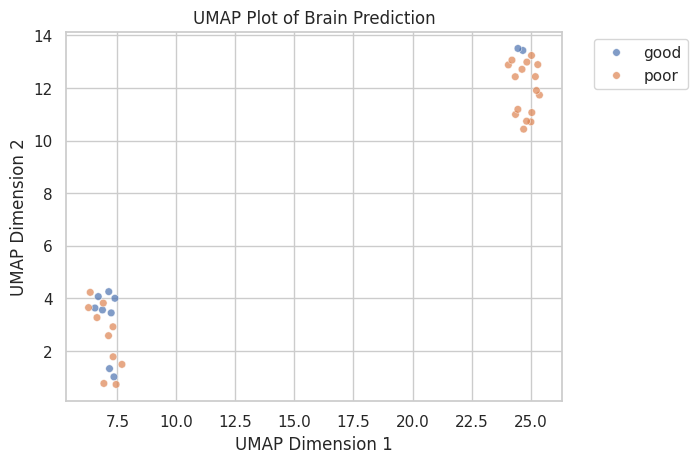

In [504]:

brain_proteomes = prot_mlmarker_df_filtered[['index', 'Brain', 'filename', 'disease_status']]
brain_proteomes = brain_proteomes.pivot_table(index=['filename', 'disease_status'], columns='index', values='Brain').reset_index()
#make a umap 
reducer = umap.UMAP()
x = brain_proteomes.copy().set_index('filename').drop(columns=['disease_status'])
embedding_pred = reducer.fit_transform(x.fillna(0))
embedding_pred_df = pd.DataFrame(embedding_pred)
embedding_pred_df['filename'] = x.index
embedding_pred_df['disease_status'] = embedding_pred_df['filename'].str.split('_').str[0]
embedding_pred_df.head()
sns.scatterplot(data=embedding_pred_df, x=embedding_pred_df[0], y=embedding_pred_df[1], hue='disease_status', s=30, alpha=0.7)

plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP Plot of Brain Prediction')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


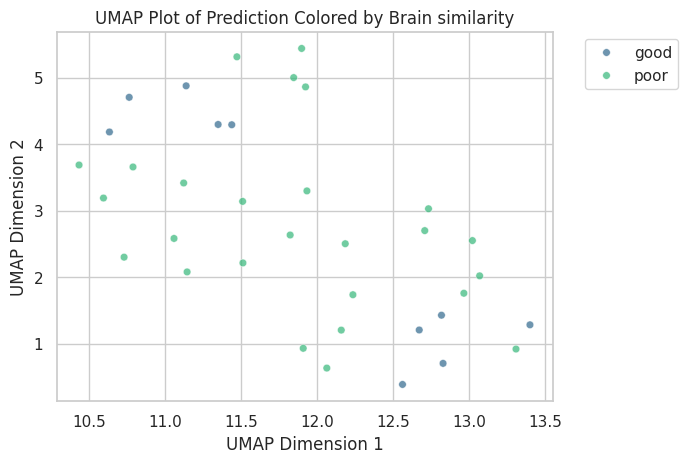

In [471]:

brain_proteomes = prot_mlmarker_df_filtered[['index', 'Monocytes', 'filename', 'disease_status']]
brain_proteomes = brain_proteomes.pivot_table(index=['filename', 'disease_status'], columns='index', values='Monocytes').reset_index()
#make a umap 
reducer = umap.UMAP()
x = brain_proteomes.copy().set_index('filename').drop(columns=['disease_status'])
embedding_pred = reducer.fit_transform(x.fillna(0))
embedding_pred_df = pd.DataFrame(embedding_pred)
embedding_pred_df['filename'] = x.index
embedding_pred_df['disease_status'] = embedding_pred_df['filename'].str.split('_').str[0]
embedding_pred_df.head()
sns.scatterplot(data=embedding_pred_df, x=embedding_pred_df[0], y=embedding_pred_df[1], hue='disease_status', s=30, alpha=0.7, palette='viridis')

plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP Plot of Prediction Colored by Brain similarity')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


# Umap and GO on all proteins

In [48]:
all_samples = prot_mlmarker_df_filtered['filename'].unique()

In [49]:
entire_df = pd.DataFrame()
for s in tqdm.tqdm(all_samples):
    path = f"/home/compomics/conode53_pride/PRIDE_DATA/PXD007592/IONBOT_v0.11.0/{s}/ionbot.first.csv"
    lengths_path = "/home/compomics/git/Projects/MLMarker_paper/uniprot_reviewed_lengths.tsv"
    file = pd.read_csv(path)
    lenghts_df = pd.read_csv(lengths_path, sep='\t')
    file_df = ionbot_first_to_prot_quant(file, lenghts_df)
    file_df['filename'] = s
    entire_df = pd.concat([entire_df, file_df])


100%|██████████| 36/36 [00:17<00:00,  2.04it/s]


In [50]:
nsaf_entire_df = entire_df.pivot_table(index='filename', columns='proteins', values='NSAF', aggfunc='sum').fillna(0)
nsaf_entire_df.head()

proteins,A0A075B6H7,A0A075B6K2,A0A075B6K4,A0A075B6K5,A0A075B6Q5,A0A075B6S6,A0A075B6S9,A0A0A0MS14,A0A0A0MS15,A0A0B4J1U7,...,Q9Y6R7,Q9Y6T7,Q9Y6U3,Q9Y6V0,Q9Y6W5,Q9Y6X2,Q9Y6X4,Q9Y6X5,Q9Y6Y0,Q9Y6Y8
filename,,,,,,,,,,,,,,,,,,,,,
good_responder_1_1.mgf.gzip,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
good_responder_1_2.mgf.gzip,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
good_responder_2_1.mgf.gzip,0.001041,0.0,0.0,0.0,0.000000,0.0,0.000619,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000270,0.000000,0.000243,0.0,0.000000,0.000000,0.0,0.000097
good_responder_2_2.mgf.gzip,0.000684,0.0,0.0,0.0,0.000672,0.0,0.000452,0.000226,0.0,0.000437,...,0.000000,0.000000,0.000222,0.000000,0.000265,0.0,0.000000,0.000058,0.0,0.000079
good_responder_3_1.mgf.gzip,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000002,0.000093,0.000087,0.000068,0.000025,0.0,0.000056,0.000000,0.0,0.000000


Get the protein content and dynamic range per sample

In [51]:
saf_entire_df = entire_df.pivot_table(index='filename', columns='proteins', values='SAF', aggfunc='sum').fillna(0)
saf_entire_df.head()

proteins,A0A075B6H7,A0A075B6K2,A0A075B6K4,A0A075B6K5,A0A075B6Q5,A0A075B6S6,A0A075B6S9,A0A0A0MS14,A0A0A0MS15,A0A0B4J1U7,...,Q9Y6R7,Q9Y6T7,Q9Y6U3,Q9Y6V0,Q9Y6W5,Q9Y6X2,Q9Y6X4,Q9Y6X5,Q9Y6Y0,Q9Y6Y8
filename,,,,,,,,,,,,,,,,,,,,,
good_responder_1_1.mgf.gzip,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000
good_responder_1_2.mgf.gzip,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000
good_responder_2_1.mgf.gzip,0.043103,0.0,0.0,0.0,0.000000,0.0,0.025641,0.000000,0.0,0.000000,...,0.000000,0.000000,0.011189,0.000000,0.010040,0.0,0.000000,0.000000,0.0,0.004
good_responder_2_2.mgf.gzip,0.025862,0.0,0.0,0.0,0.025424,0.0,0.017094,0.008547,0.0,0.016529,...,0.000000,0.000000,0.008392,0.000000,0.010040,0.0,0.000000,0.002208,0.0,0.003
good_responder_3_1.mgf.gzip,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000185,0.007463,0.006993,0.005445,0.002008,0.0,0.004478,0.000000,0.0,0.000


/tmp/ipykernel_45284/70252780.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_df, x='filename', y='SAF', palette=colors)


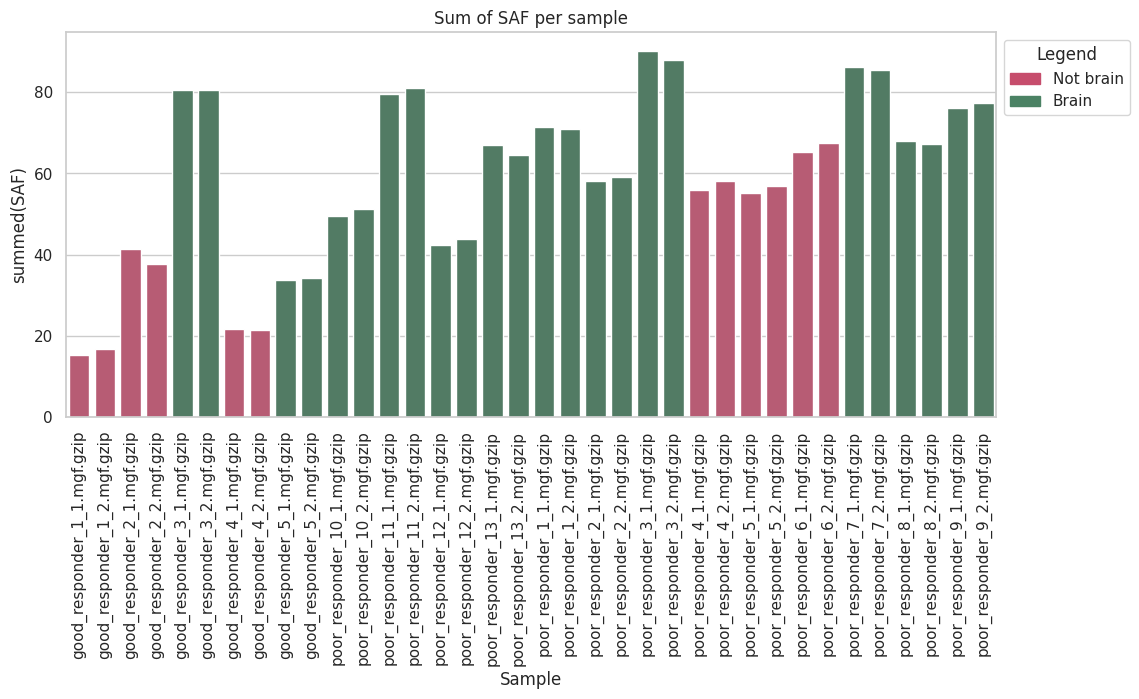

In [52]:
#import mpatches
import matplotlib.patches as mpatches

# per filename, barplot with the number of proteins
r = sns.diverging_palette(0, 145, s=60)[0]
g = sns.diverging_palette(0, 145, s=60)[-1]
colors = [r if x in set(poor_notbrain) | set(good_notbrain) else g for x in saf_entire_df.index]

# make a seaborn barplot of saf_entire_df.sum(axis=1)
plot_df = saf_entire_df.sum(axis=1).reset_index()
plot_df.columns = ['filename', 'SAF']

plt.figure(figsize=(12, 5))
sns.barplot(data=plot_df, x='filename', y='SAF', palette=colors)
plt.xticks(rotation=90)
plt.title('Sum of SAF per sample')
plt.xlabel('Sample')
plt.ylabel('summed(SAF)')

# add legend colors
r_patch = mpatches.Patch(color=r, label='Not brain')
g_patch = mpatches.Patch(color=g, label='Brain')
plt.legend(handles=[r_patch, g_patch], loc='upper left', bbox_to_anchor=(1, 1), title='Legend')

plt.show()


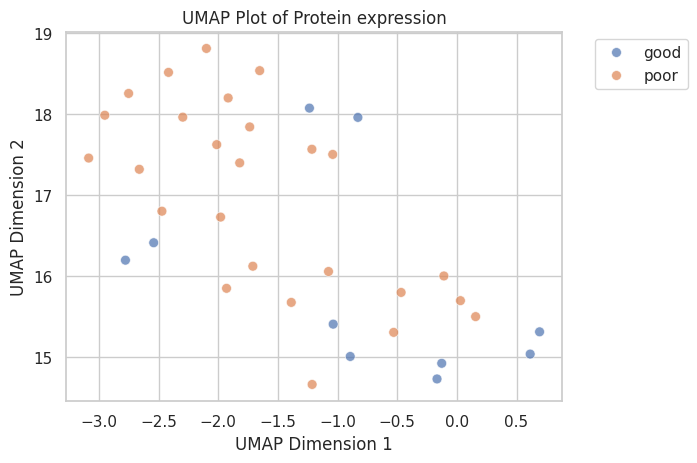

In [53]:
#make a umap 
reducer = umap.UMAP()
x = nsaf_entire_df.copy()
embedding_pred = reducer.fit_transform(x.fillna(0))
embedding_pred_df = pd.DataFrame(embedding_pred)
embedding_pred_df['filename'] = x.index
embedding_pred_df['disease_status'] = embedding_pred_df['filename'].str.split('_').str[0]
sns.scatterplot(data=embedding_pred_df, x=embedding_pred_df[0], y=embedding_pred_df[1], hue='disease_status', s=50, alpha=0.7)

plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP Plot of Protein expression')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [62]:
samples = [poor_brain, poor_notbrain, good_notbrain, good_brain]
sample_names = ['Poor brain', 'Poor not brain', 'Good not brain', 'Good brain']

for i, sample in enumerate(samples):
    print(sample_names[i])
    #select the 1000 highest values, link that back to its proteins and continue with that list
    top_100_index = list(set(prot_mlmarker_df_filtered[(prot_mlmarker_df_filtered['filename'].isin(sample))].set_index('index').iloc[:,:-4].max(axis=1).nlargest(1000).index))
    print(len(top_100_index))
    godf = get_go_enrichment(top_100_index)
    visualise_go_enrichment(godf, title=sample_names[i], max_bars=20, proteins=len(top_100_index))

Poor brain
105


Poor not brain
318


Good not brain
390


Good brain
382


# Four subpopulations

Get the protein level SHAP values and draw an upsetplot

In [76]:
#true_poor is if the disease_status is poor and the cluster is 0
poor_brain = embedding_pred_df[(embedding_pred_df['disease_status'] == 'poor') & (embedding_pred_df['cluster'] == 0)]['filename'].tolist()
#false poor is if the disease_status is poor and the cluster is 1
poor_notbrain = embedding_pred_df[(embedding_pred_df['disease_status'] == 'poor') & (embedding_pred_df['cluster'] == 1)]['filename'].tolist()
#true_good is if the disease_status is good and the cluster is 1
good_notbrain = embedding_pred_df[(embedding_pred_df['disease_status'] == 'good') & (embedding_pred_df['cluster'] == 1)]['filename'].tolist()
#false good is if the disease_status is good and the cluster is 0
good_brain = embedding_pred_df[(embedding_pred_df['disease_status'] == 'good') & (embedding_pred_df['cluster'] == 0)]['filename'].tolist()

print(len(poor_brain), len(poor_notbrain), len(good_notbrain), len(good_brain))

20 6 6 4


In [57]:
len(list(unique_protein_dict.values())[0]), len(list(unique_protein_dict.values())[1])

(2717, 3480)

In [15]:
pxd = "PXD007592"
base_path = f"/home/compomics/conode*/PRIDE_DATA"  
lengths_path = "/home/compomics/git/Projects/MLMarker_paper/uniprot_reviewed_lengths.tsv"
prot_mlmarker_df, unique_protein_dict = get_mlmarker_dataframe(pxd, base_path, lengths_path, dev=True, tissue_level=False)
prot_mlmarker_df['disease_status'] = prot_mlmarker_df['filename'].str.split('_').str[0]
prot_mlmarker_df = prot_mlmarker_df.reset_index().merge(embedding_pred_df[['filename', 'cluster']], on='filename', how='left')
prot_mlmarker_df.head()

,index,Brain,Kidney,Testis,Pituitary gland,Lung,Adrenal gland,Colon,Monocytes,Thyroid,...,Salivary gland,Nasal Polyps,Tonsil,B-cells,Small intestine,Parotid gland,PXD_folder,filename,disease_status,cluster
0,A0A075B6H7,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.0,0.00000,0.0,0.0,0.0,0.00000,PXD007592,poor_responder_12_1.mgf.gzip,poor,0
1,A0A075B6H8,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.0,0.00000,0.0,0.0,0.0,0.00000,PXD007592,poor_responder_12_1.mgf.gzip,poor,0
2,A0A075B6H9,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.0,0.00000,-0.0,0.0,0.0,0.00000,PXD007592,poor_responder_12_1.mgf.gzip,poor,0
3,A0A075B6I0,0.00015,0.00002,0.00002,0.00001,0.00002,0.00001,-0.00011,0.00002,0.00001,...,0.0,-0.00028,0.0,0.0,0.0,0.00002,PXD007592,poor_responder_12_1.mgf.gzip,poor,0
4,A0A075B6I9,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.0,0.00000,0.0,0.0,0.0,0.00000,PXD007592,poor_responder_12_1.mgf.gzip,poor,0


In [58]:
#only keep proteins that are present in the sample (remove absent features)
prot_mlmarker_df2 = prot_mlmarker_df[prot_mlmarker_df.apply(lambda x: x['index'] in unique_protein_dict[x['filename']], axis=1)]


In [60]:
prot_mlmarker_df = prot_mlmarker_df2.copy()

In [61]:
# Protein level info
unique_mlmarker_proteins = set(prot_mlmarker_df['index'].unique())
len(unique_mlmarker_proteins)   
unique_protein_values = list(set(sum(unique_protein_dict.values(), [])))
prot_mlmarker_df_filtered = prot_mlmarker_df[prot_mlmarker_df['index'].isin(unique_protein_values)]
print(prot_mlmarker_df.shape, prot_mlmarker_df_filtered.shape)

(70141, 39) (70141, 39)


In [62]:
prot_mlmarker_df_filtered

,index,Brain,Kidney,Testis,Pituitary gland,Lung,Adrenal gland,Colon,Monocytes,Thyroid,...,Salivary gland,Nasal Polyps,Tonsil,B-cells,Small intestine,Parotid gland,PXD_folder,filename,disease_status,cluster
0,A0A075B6H7,0.0,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.0,...,0.00000,0.0,0.0,0.00000,0.00000,0.00000,PXD007592,poor_responder_12_1.mgf.gzip,poor,0
14,A0A0A0MS14,0.0,0.00002,0.00000,0.0,0.00001,0.00000,0.00001,0.00000,0.0,...,0.00000,0.0,0.0,0.00000,0.00000,0.00000,PXD007592,poor_responder_12_1.mgf.gzip,poor,0
33,A0A0C4DH35,0.0,0.00000,0.00000,0.0,-0.00000,0.00000,0.00000,0.00000,0.0,...,0.00000,0.0,0.0,0.00000,0.00000,0.00000,PXD007592,poor_responder_12_1.mgf.gzip,poor,0
34,A0A0C4DH36,0.0,0.00000,0.00000,0.0,-0.00000,0.00000,0.00000,0.00000,0.0,...,0.00000,0.0,0.0,0.00000,0.00000,0.00000,PXD007592,poor_responder_12_1.mgf.gzip,poor,0
43,A0AVT1,0.0,-0.00001,-0.00001,0.0,0.00001,-0.00000,0.00001,0.00000,0.0,...,0.00000,0.0,0.0,-0.00002,0.00000,0.00000,PXD007592,poor_responder_12_1.mgf.gzip,poor,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215233,Q9Y6U3,0.0,0.00001,0.00000,0.0,0.00002,0.00000,0.00009,-0.00003,0.0,...,0.00004,0.0,0.0,0.00000,0.00002,-0.00004,PXD007592,poor_responder_10_2.mgf.gzip,poor,0
215237,Q9Y6W5,0.0,0.00000,0.00000,-0.0,-0.00000,0.00001,0.00000,0.00003,0.0,...,0.00000,0.0,0.0,-0.00009,0.00000,0.00000,PXD007592,poor_responder_10_2.mgf.gzip,poor,0
215239,Q9Y6X5,0.0,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.0,...,0.00000,0.0,0.0,0.00000,0.00000,0.00000,PXD007592,poor_responder_10_2.mgf.gzip,poor,0
215242,Q9Y6Y0,0.0,0.00000,0.00000,0.0,0.00000,0.00000,0.00000,0.00000,0.0,...,0.00000,0.0,0.0,0.00000,-0.00000,0.00000,PXD007592,poor_responder_10_2.mgf.gzip,poor,0


In [81]:
# group protmlmarkerdf  into clusters: poor_brain, poor_notbrain, good_notbrain, good_brain based on filenames column
prot_mlmarker_df_filtered['cluster'] = prot_mlmarker_df_filtered['filename'].apply(lambda x: 'poor_brain' if x in poor_brain else ('poor_notbrain' if x in poor_notbrain else ('good_notbrain' if x in good_notbrain else 'good_brain')))
prot_mlmarker_df_filtered['predicted'] = prot_mlmarker_df_filtered['cluster'].str.split('_').str[-1]
#groupby cluster and where index is the same, get the average value
cluster_grouped_protein_shaps = prot_mlmarker_df_filtered.drop(columns=['PXD_folder', 'filename', 'disease_status', 'predicted']).groupby(['cluster', 'index']).mean()
#cluster_grouped_protein_shaps = prot_mlmarker_df_filtered.drop(columns=['PXD_folder', 'filename', 'disease_status', 'cluster']).groupby(['predicted', 'index']).mean()


In [82]:
cluster_grouped_protein_shaps.loc['good_brain'].shape, cluster_grouped_protein_shaps.loc['good_notbrain'].shape, cluster_grouped_protein_shaps.loc['poor_brain'].shape, cluster_grouped_protein_shaps.loc['poor_notbrain'].shape

((2649, 34), (2277, 34), (4003, 34), (3491, 34))

In [83]:
cluster_grouped_protein_shaps

Brain    Kidney    Testis  Pituitary gland  \
cluster       index                                                       
good_brain    A0A075B6H7  0.000000  0.000000  0.000000              0.0   
              A0A0A0MS15  0.000000  0.000000  0.000000              0.0   
              A0A0B4J1V0  0.000100  0.000010  0.000000              0.0   
              A0A0C4DH35  0.000000  0.000000  0.000000              0.0   
              A0AVT1     -0.000015 -0.000002  0.000118              0.0   
...                            ...       ...       ...              ...   
poor_notbrain Q9Y6W5      0.000000  0.000007  0.000003              0.0   
              Q9Y6X5      0.000000  0.000000  0.000000              0.0   
              Q9Y6X9      0.000000  0.000000  0.000000              0.0   
              Q9Y6Y0      0.000000  0.000000  0.000000              0.0   
              Q9Y6Y8      0.000000 -0.000016  0.000040              0.0   

                              Lung  Adrenal gland    Colon  Monocytes  \
cluster       index                                                     
good_brain    A0A075B6H7  0.000000        0.00000  0.00000   0.000000   
              A0A0A0MS15  0.000010        0.00000  0.00000   0.000000   
              A0A0B4J1V0  0.000000        0.00000 -0.00004   0.000020   
              A0A0C4DH35  0.000000        0.00000  0.00000   0.000000   
              A0AVT1     -0.000008        0.00000 -0.00001   0.000000   
...                            ...            ...      ...        ...   
poor_notbrain Q9Y6W5      0.000000        0.00001  0.00000   0.000035   
              Q9Y6X5      0.000000        0.00000  0.00000   0.000000   
              Q9Y6X9      0.000000        0.00000  0.00000   0.000000   
              Q9Y6Y0      0.000000        0.00000  0.00000   0.000000   
              Q9Y6Y8      0.000004        0.00000  0.00002   0.000000   

                          Thyroid  Adipose tissue  ...    Rectum  Placenta  \
cluster       index                                ...                       
good_brain    A0A075B6H7      0.0        0.000000  ... -0.000010   0.00000   
              A0A0A0MS15      0.0       -0.000010  ...  0.000000   0.00000   
              A0A0B4J1V0      0.0        0.000000  ...  0.000000   0.00000   
              A0A0C4DH35      0.0        0.000000  ...  0.000000   0.00000   
              A0AVT1          0.0       -0.000008  ...  0.000000   0.00000   
...                           ...             ...  ...       ...       ...   
poor_notbrain Q9Y6W5          0.0        0.000010  ...  0.000000   0.00002   
              Q9Y6X5          0.0        0.000000  ...  0.000000   0.00000   
              Q9Y6X9          0.0        0.000000  ...  0.000000   0.00000   
              Q9Y6Y0          0.0        0.000000  ...  0.000000   0.00000   
              Q9Y6Y8          0.0       -0.000034  ... -0.000018   0.00000   

                          Duodenum  Oviduct  Salivary gland  Nasal Polyps  \
cluster       index                                                         
good_brain    A0A075B6H7   0.00000      0.0             0.0        0.0000   
              A0A0A0MS15  -0.00001      0.0             0.0        0.0000   
              A0A0B4J1V0   0.00000      0.0             0.0       -0.0001   
              A0A0C4DH35   0.00000      0.0             0.0        0.0000   
              A0AVT1       0.00000      0.0             0.0        0.0000   
...                            ...      ...             ...           ...   
poor_notbrain Q9Y6W5       0.00000      0.0             0.0        0.0000   
              Q9Y6X5       0.00000      0.0             0.0        0.0000   
              Q9Y6X9       0.00000      0.0             0.0        0.0000   
              Q9Y6Y0       0.00000      0.0             0.0        0.0000   
              Q9Y6Y8       0.00000      0.0             0.0        0.0000   

                          Tonsil   B-cells  Small intestine  Parotid gland  
cluster  

<Axes: ylabel='cluster'>

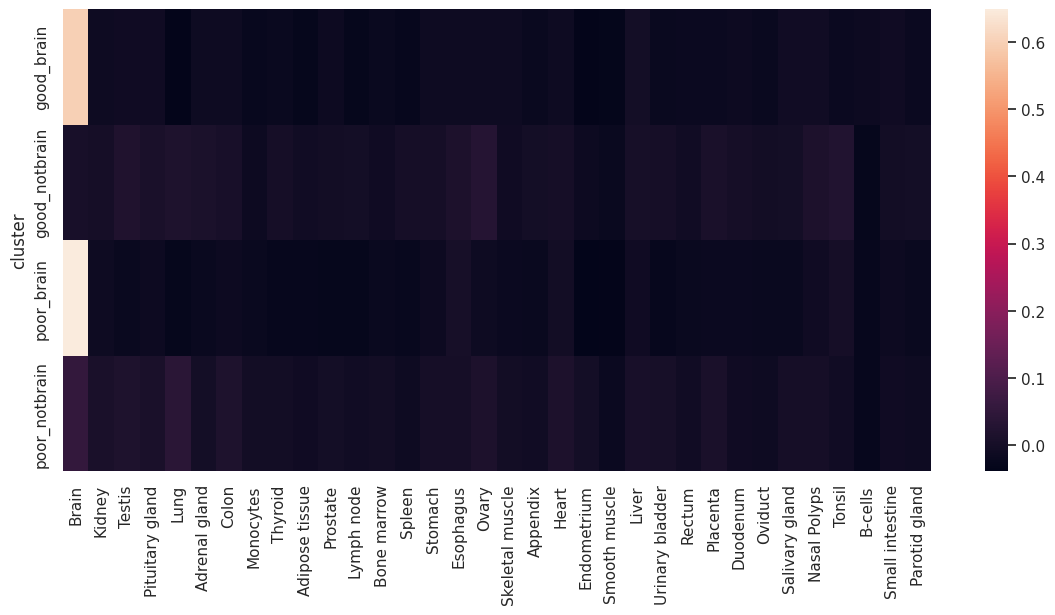

In [85]:
plt.figure(figsize=(14, 6))
sns.heatmap(cluster_grouped_protein_shaps.groupby('cluster').sum())

### make a boxplot of the spread of SHAP values per cluster

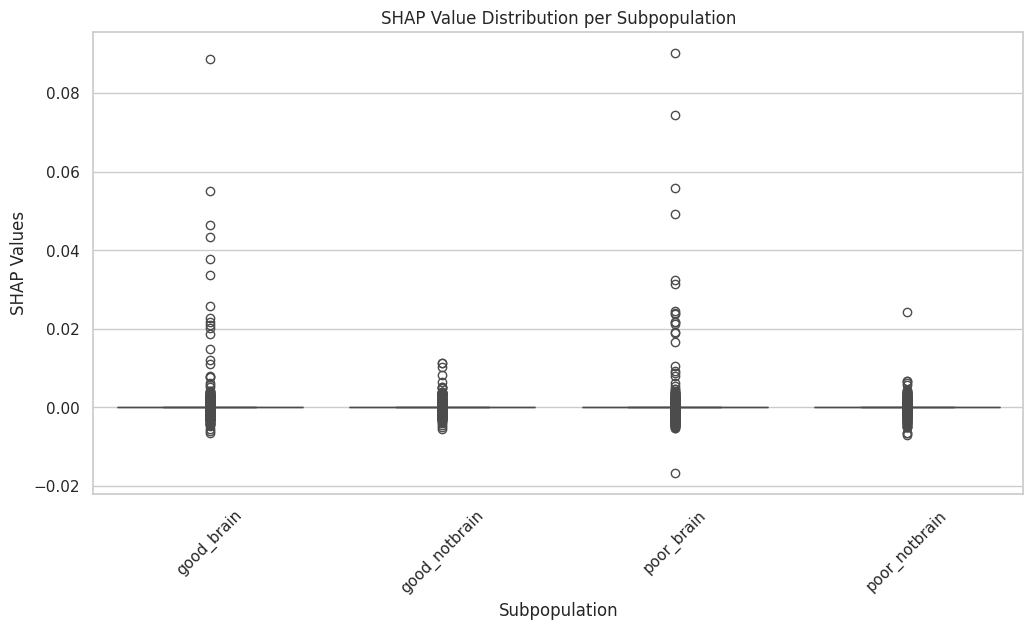

In [99]:

df_reset = cluster_grouped_protein_shaps.reset_index()  #

# Drop the 'index' column, keeping only 'cluster'
df_reset = df_reset.drop(columns=["index"])

# Melt the dataframe to long format
df_melted = df_reset.melt(id_vars=["cluster"], var_name="Tissue", value_name="Expression")

# Create the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x="cluster", y="Expression", data=df_melted)

# Improve visualization
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.xlabel("Subpopulation")
plt.ylabel("SHAP Values")
plt.title("SHAP Value Distribution per Subpopulation")

plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def find_top_differentiating_proteins(df, tissue_name, top_n=15):
    """
    Compare proteins' predictive values across clusters for a specific tissue
    and identify the top proteins with the largest differences.
    """
    # Step 1: Select data for the specific tissue
    tissue_data = df[tissue_name]

    # Step 2: Compute the range (max - min) for each protein across clusters
    protein_variability = tissue_data.groupby("index").agg(lambda x: x.max() - x.min())

    # Step 3: Identify the top N proteins with the highest variability
    top_proteins = protein_variability.nlargest(top_n)

    # Step 4: Prepare data for visualization
    top_protein_data = tissue_data.loc[tissue_data.index.get_level_values("index").isin(top_proteins.index)]

    # Step 5: Unstack to create a heatmap-friendly format
    heatmap_data = top_protein_data.unstack(level=0) 
    
    # Step 6: Plot heatmap
    plt.figure(figsize=(10, 6))
    g = sns.clustermap(
        heatmap_data,
        annot=False,
        cmap=sns.diverging_palette(0, 145, s=60, as_cmap=True),
        center=0,
        cbar_kws={"label": "Predictive Value"},
        fmt=".5f",
    )
    plt.title(f"Top {top_n} Differentiating Proteins for {tissue_name}")
    plt.xlabel("Clusters")
    plt.ylabel("Proteins")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
   # Extract row order from dendrogram
    ordered_proteins = heatmap_data.index[g.dendrogram_row.reordered_ind]

    return ordered_proteins.tolist() 


# Example usage
# Call the function for a specific tissue (e.g., "Brain")
top_proteins = find_top_differentiating_proteins(cluster_grouped_protein_shaps, tissue_name="Brain", top_n=25)
print("Top Differentiating Proteins:")
print(top_proteins)
top_proteins_info = []
for p in top_proteins:
    top_proteins_info.append(mlmarker.explainability.get_protein_info(p))
top_proteins_info = pd.DataFrame(top_proteins_info)
    

In [71]:
pd.set_option('display.max_colwidth', None)
top_proteins_info

,id,entry name,protein_names,tissue_specificity
0,P20916,MAG_HUMAN,Myelin-associated glycoprotein (Siglec-4a),"TISSUE SPECIFICITY: Both isoform 1 and isoform 2 are detected in myelinated structures in the central and peripheral nervous system, in periaxonal myelin and at Schmidt-Lanterman incisures (PubMed:6200494, PubMed:9495552). Detected in optic nerve, in oligodendroglia and in periaxonal myelin sheaths (PubMed:6200494). Detected in compact myelin (at protein level) (PubMed:6200494). Both isoform 1 and isoform 2 are detected in the central and peripheral nervous system (PubMed:9495552). {ECO:0000269|PubMed:6200494, ECO:0000269|PubMed:9495552}."
1,Q92752,TENR_HUMAN,Tenascin-R (TN-R) (Janusin) (Restrictin),TISSUE SPECIFICITY: Brain specific. {ECO:0000269|PubMed:8626505}.
2,P17600,SYN1_HUMAN,Synapsin-1 (Brain protein 4.1) (Synapsin I),NaN
3,Q96GW7,PGCB_HUMAN,Brevican core protein (Brain-enriched hyaluronan-binding protein) (BEHAB) (Chondroitin sulfate proteoglycan 7),"TISSUE SPECIFICITY: Expressed in the retina, specifically in the inner nuclear layer, inner plexiform layer and ganglion cell layer (at protein level) (PubMed:29777959). Detected in cerebrospinal fluid (at protein level) (PubMed:25326458). Detected in urine (at protein level) (PubMed:37453717). {ECO:0000269|PubMed:25326458, ECO:0000269|PubMed:29777959, ECO:0000269|PubMed:37453717}."
4,P60201,MYPR_HUMAN,Myelin proteolipid protein (PLP) (Lipophilin),NaN
5,P09543,CN37_HUMAN,"2',3'-cyclic-nucleotide 3'-phosphodiesterase (CNP) (CNPase) (EC 3.1.4.37)",NaN
6,P12036,NFH_HUMAN,Neurofilament heavy polypeptide (NF-H) (200 kDa neurofilament protein) (Neurofilament triplet H protein),NaN
7,P02689,MYP2_HUMAN,Myelin P2 protein (Peripheral myelin protein 2),NaN
8,Q6UWR7,ENPP6_HUMAN,Glycerophosphocholine cholinephosphodiesterase ENPP6 (GPC-Cpde) (EC 3.1.4.-) (EC 3.1.4.38) (Choline-specific glycerophosphodiester phosphodiesterase) (Ectonucleotide pyrophosphatase/phosphodiesterase family member 6) (E-NPP 6) (NPP-6),"TISSUE SPECIFICITY: Predominantly expressed in kidney and brain. In the kidney, expressed specifically in the proximal tubules and thin descending limbs of Henle (at protein level). {ECO:0000269|PubMed:15788404}."
9,Q8N3J6,CADM2_HUMAN,Cell adhesion molecule 2 (Immunoglobulin superfamily member 4D) (IgSF4D) (Nectin-like protein 3) (NECL-3) (Synaptic cell adhesion molecule 2) (SynCAM 2),NaN


Just comparing brain vs not brain <br>
Which proteins are responsible for the NOT brain predictions and are these relate dot phenotype switch of cancers? Do they match the original publication? Are there proteins negatively impacting the brain prediction?

In [50]:
cluster_grouped_protein_shaps.head()

Brain    Kidney    Testis  Pituitary gland     Lung  \
predicted index                                                                
brain     A0A075B6H7  0.000000  0.000000  0.000000         0.000000  0.00000   
          A0A075B6H8  0.000000  0.000000  0.000000         0.000000  0.00000   
          A0A075B6I0  0.000147  0.000018  0.000018         0.000011  0.00002   
          A0A075B6K2  0.000000  0.000000  0.000000         0.000000  0.00000   
          A0A075B6K4  0.000000  0.000000  0.000000         0.000000  0.00000   

                      Adrenal gland     Colon  Monocytes   Thyroid  \
predicted index                                                      
brain     A0A075B6H7        0.00000  0.000000   0.000000  0.000000   
          A0A075B6H8        0.00000  0.000000   0.000000  0.000000   
          A0A075B6I0        0.00001 -0.000077   0.000017  0.000008   
          A0A075B6K2        0.00000  0.000000   0.000000  0.000000   
          A0A075B6K4        0.00000  0.000000   0.000000  0.000000   

                      Adipose tissue  ...    Rectum  Placenta  Duodenum  \
predicted index                       ...                                 
brain     A0A075B6H7        0.000000  ... -0.000010  0.000000  0.000000   
          A0A075B6H8        0.000000  ...  0.000000  0.000000  0.000000   
          A0A075B6I0        0.000011  ...  0.000009 -0.000044  0.000008   
          A0A075B6K2        0.000000  ...  0.000000  0.000000  0.000000   
          A0A075B6K4        0.000000  ...  0.000000  0.000000  0.000000   

                      Oviduct  Salivary gland  Nasal Polyps  Tonsil  \
predicted index                                                       
brain     A0A075B6H7  0.00000    0.000000e+00      0.000000     0.0   
          A0A075B6H8  0.00000    0.000000e+00      0.000000     0.0   
          A0A075B6I0  0.00001    8.333333e-07     -0.000375     0.0   
          A0A075B6K2  0.00000    0.000000e+00      0.000000     0.0   
          A0A075B6K4  0.00000    0.000000e+00      0.000000     0.0   

                           B-cells  Small intestine  Parotid gland  
predicted index                                                     
brain     A0A075B6H7  0.000000e+00              0.0       0.000000  
          A0A075B6H8  0.000000e+00              0.0       0.000000  
          A0A075B6I0  8.333333e-07              0.0       0.000025  
          A0A075B6K2  0.000000e+00              0.0       0.000000  
          A0A075B6K4  0.000000e+00              0.0       0.000000  

[5 rows x 34 columns]

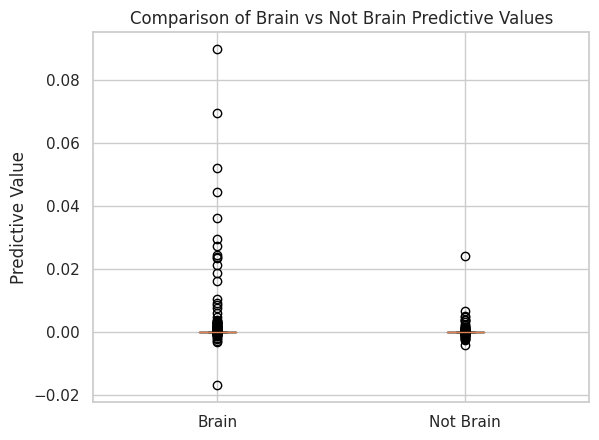

In [68]:
fig, ax = plt.subplots()

ax.boxplot([cluster_grouped_protein_shaps.loc['brain']['Brain'], cluster_grouped_protein_shaps.loc['notbrain']['Brain']])
ax.set_xticklabels(['Brain', 'Not Brain'])
ax.set_ylabel('Predictive Value')
ax.set_title('Comparison of Brain vs Not Brain Predictive Values')

plt.show()


<Axes: xlabel='predicted', ylabel='index'>

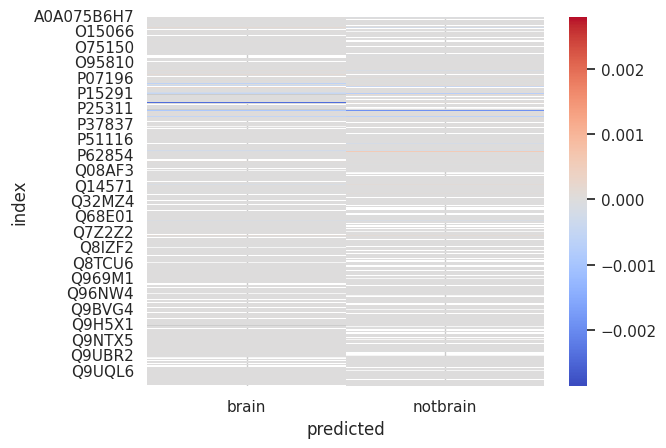

In [79]:
sns.heatmap(cluster_grouped_protein_shaps['Monocytes'].reset_index().pivot_table(index='index', columns='predicted', values='Monocytes'), cmap='coolwarm', center=0)

In [69]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Box(
    y=cluster_grouped_protein_shaps.loc['brain']['Brain'],
    name='Brain',
    hovertext=cluster_grouped_protein_shaps.loc['brain']['Brain'].index,
    boxpoints='all',
    jitter=0.3,
    pointpos=-1.8,
    marker=dict(
        color='blue'
    )
))

fig.add_trace(go.Box(
    y=cluster_grouped_protein_shaps.loc['notbrain']['Brain'],
    name='Not Brain',
    hovertext=cluster_grouped_protein_shaps.loc['notbrain']['Brain'].index,
    boxpoints='all',
    jitter=0.3,
    pointpos=-1.8,
    marker=dict(
        color='orange'
    )
))

fig.update_layout(
    title='Comparison of Brain vs Not Brain Predictive Values',
    yaxis=dict(
        title='Predictive Value'
    ),
    xaxis=dict(
        title='Tissue'
    )
)

fig.show()


In [43]:
filtered_cluster_grouped_protein_shaps

,predicted,index,Brain,Kidney,Testis,Pituitary gland,Lung,Adrenal gland,Colon,Monocytes,...,Rectum,Placenta,Duodenum,Oviduct,Salivary gland,Nasal Polyps,Tonsil,B-cells,Small intestine,Parotid gland
0,brain,A0A075B6H7,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,-0.000010,0.000000,0.000000,0.00000,0.000000e+00,0.000000,0.0,0.000000e+00,0.0,0.000000
1,brain,A0A075B6H8,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000e+00,0.000000,0.0,0.000000e+00,0.0,0.000000
2,brain,A0A075B6I0,0.000147,1.833333e-05,0.000018,0.000011,0.000020,0.00001,-0.000077,0.000017,...,0.000009,-0.000044,0.000008,0.00001,8.333333e-07,-0.000375,0.0,8.333333e-07,0.0,0.000025
3,brain,A0A075B6K2,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000e+00,0.000000,0.0,0.000000e+00,0.0,0.000000
4,brain,A0A075B6K4,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000e+00,0.000000,0.0,0.000000e+00,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9155,notbrain,Q9Y6W5,0.000000,1.833333e-05,0.000002,0.000000,0.000002,0.00001,0.000000,0.000033,...,0.000000,0.000010,0.000000,0.00000,0.000000e+00,0.000000,0.0,-1.050000e-04,0.0,0.000000
9156,notbrain,Q9Y6X5,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000e+00,0.000000,0.0,0.000000e+00,0.0,0.000000
9157,notbrain,Q9Y6X9,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000e+00,0.000000,0.0,0.000000e+00,0.0,0.000000
9158,notbrain,Q9Y6Y0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000e+00,0.000000,0.0,0.000000e+00,0.0,0.000000


KeyError: 'brain'

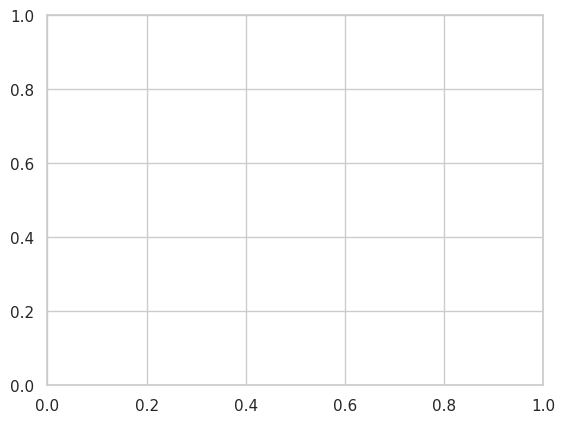

In [42]:
#Filter out only on present proteins
unique_protein_dict_values = list(set(sum(unique_protein_dict.values(), [])))
# cluster_grouped_protein_shaps.reset_index(inplace=True)
filtered_cluster_grouped_protein_shaps = cluster_grouped_protein_shaps[cluster_grouped_protein_shaps['index'].isin(unique_protein_dict_values)]

fig, ax = plt.subplots()

ax.boxplot([filtered_cluster_grouped_protein_shaps.loc['brain']['Brain'], filtered_cluster_grouped_protein_shaps.loc['notbrain']['Brain']])
ax.set_xticklabels(['Brain', 'Not Brain'])
ax.set_ylabel('Predictive Value')
ax.set_title('Comparison of Brain vs Not Brain Predictive Values')

plt.show()


<Axes: ylabel='Brain'>

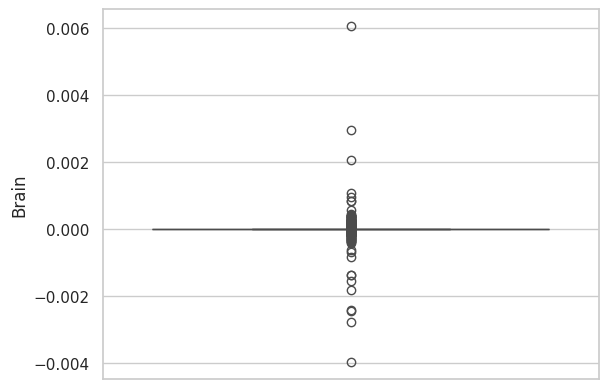

In [34]:
sns.boxplot(cluster_grouped_protein_shaps.loc['notbrain']['Brain'])

Abundance of interesting proteins

In [87]:
good_notbrain

['good_responder_4_1.mgf.gzip',
 'good_responder_2_1.mgf.gzip',
 'good_responder_2_2.mgf.gzip',
 'good_responder_1_1.mgf.gzip',
 'good_responder_1_2.mgf.gzip',
 'good_responder_4_2.mgf.gzip']

In [88]:
# group protmlmarkerdf  into clusters: poor_brain, poor_notbrain, good_notbrain, good_brain based on filenames column
nsaf_entire_df.reset_index(inplace=True)
nsaf_entire_df['cluster'] = nsaf_entire_df['filename'].apply(lambda x: 'poor_brain' if x in poor_brain else ('poor_notbrain' if x in poor_notbrain else ('good_notbrain' if x in good_notbrain else 'good_brain')))
nsaf_entire_df.head()

proteins,filename,A0A075B6H7,A0A075B6K2,A0A075B6K4,A0A075B6K5,A0A075B6Q5,A0A075B6S6,A0A075B6S9,A0A0A0MS14,A0A0A0MS15,...,Q9Y6T7,Q9Y6U3,Q9Y6V0,Q9Y6W5,Q9Y6X2,Q9Y6X4,Q9Y6X5,Q9Y6Y0,Q9Y6Y8,cluster
0,good_responder_1_1.mgf.gzip,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,good_notbrain
1,good_responder_1_2.mgf.gzip,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,good_notbrain
2,good_responder_2_1.mgf.gzip,0.001041,0.0,0.0,0.0,0.000000,0.0,0.000619,0.000000,0.0,...,0.000000,0.000270,0.000000,0.000243,0.0,0.000000,0.000000,0.0,0.000097,good_notbrain
3,good_responder_2_2.mgf.gzip,0.000684,0.0,0.0,0.0,0.000672,0.0,0.000452,0.000226,0.0,...,0.000000,0.000222,0.000000,0.000265,0.0,0.000000,0.000058,0.0,0.000079,good_notbrain
4,good_responder_3_1.mgf.gzip,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.000093,0.000087,0.000068,0.000025,0.0,0.000056,0.000000,0.0,0.000000,good_brain


In [162]:
nsaf_entire_df['response_state'] = nsaf_entire_df['cluster'].str.split('_').str[0]
nsaf_entire_df.to_csv('NSAF_values.csv')

In [100]:
neuronal = ["P17600",
"P06702",
"P05109",
"P32004",
"Q8N3J6",
"Q92777"]
ecm = ["P55268",
"O15230",
"P98160",
"Q96RW7",
"P07996",
"P25391",
"P98160"]
mapk = ["O60841",
"P02751",
"P19022",
"P23588",
"P27361",
"P28482",
"P53779",
"P55884",
"P56537",
"Q14152",
"Q14232",
"Q9UPT6"]

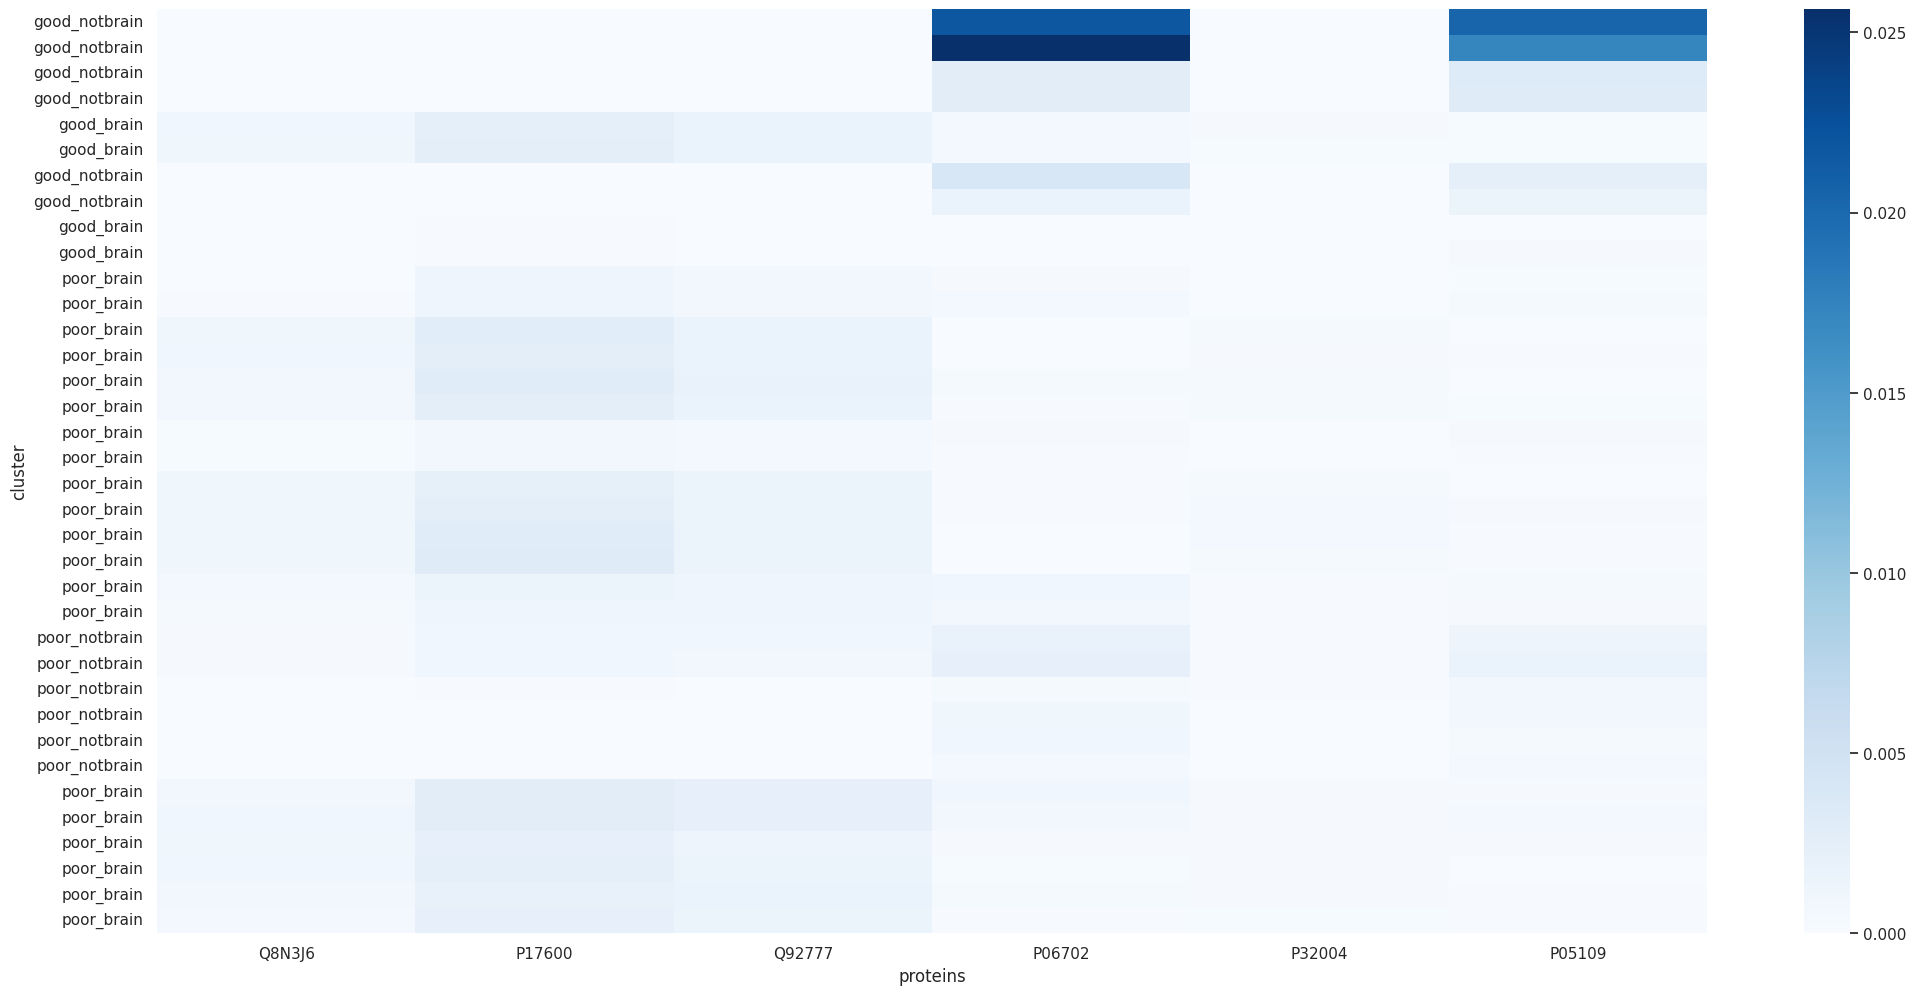

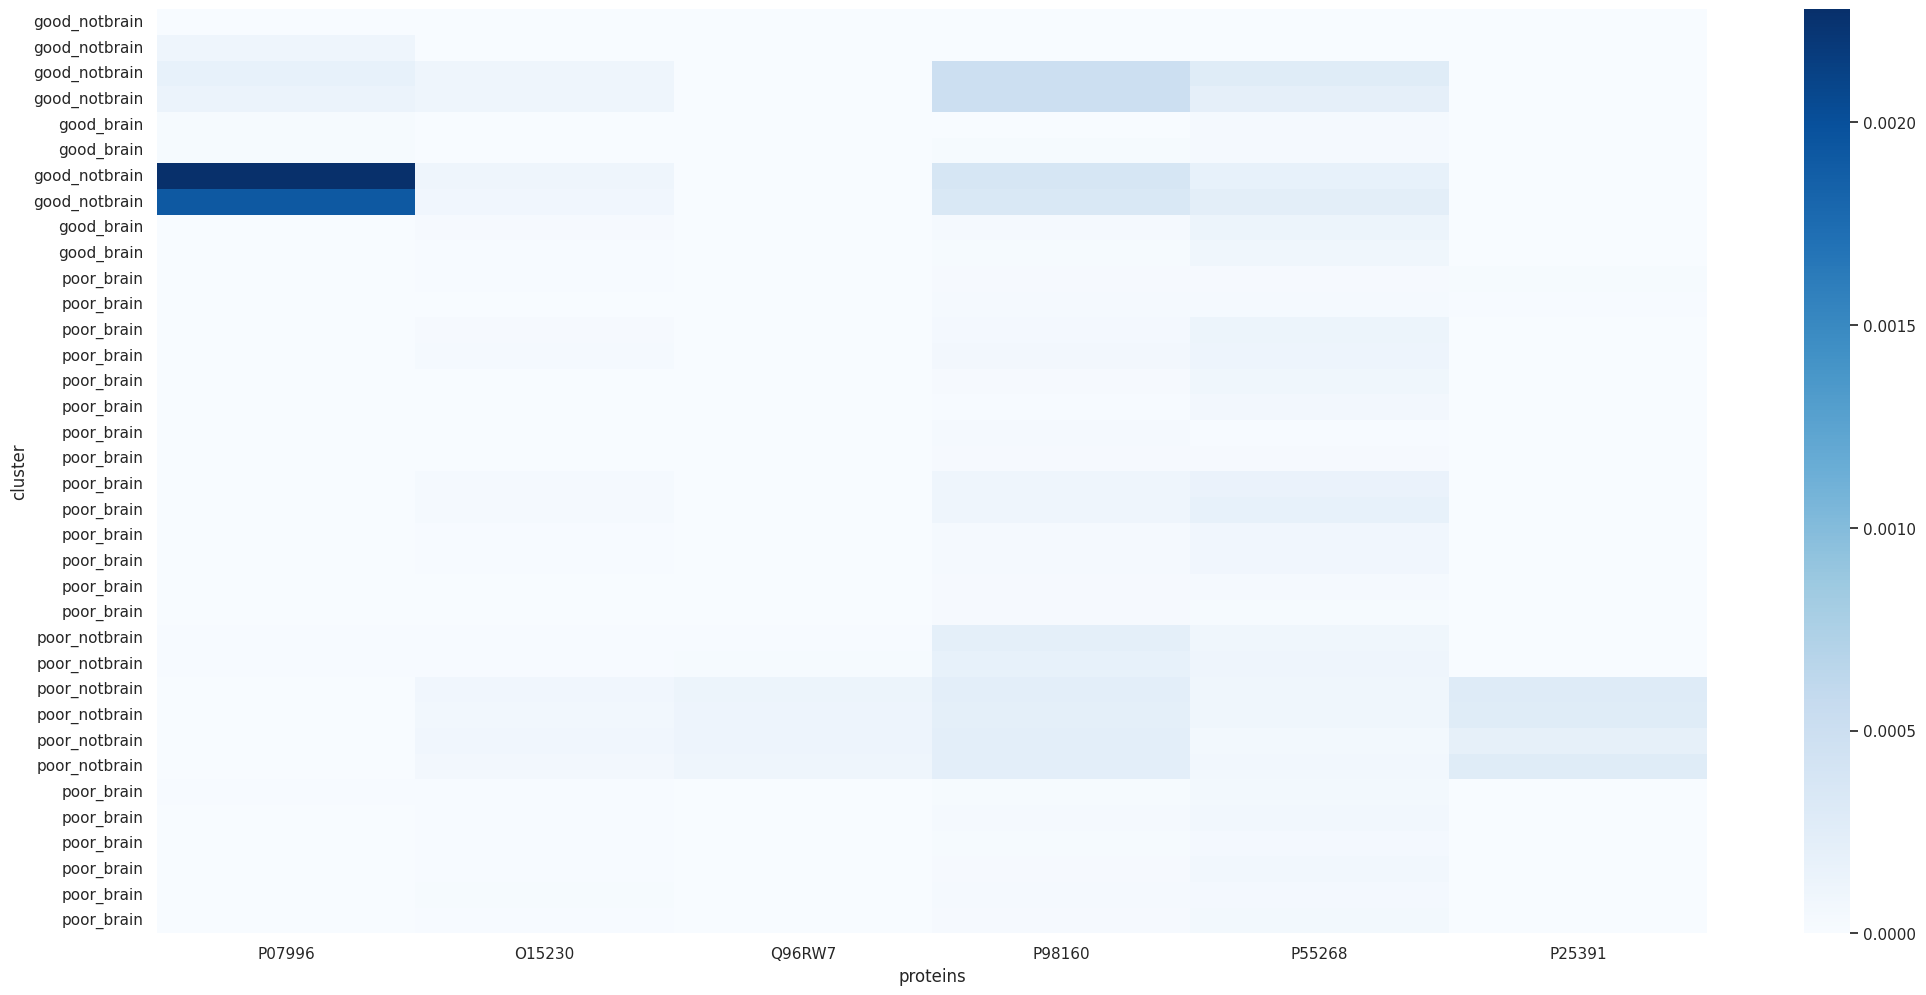

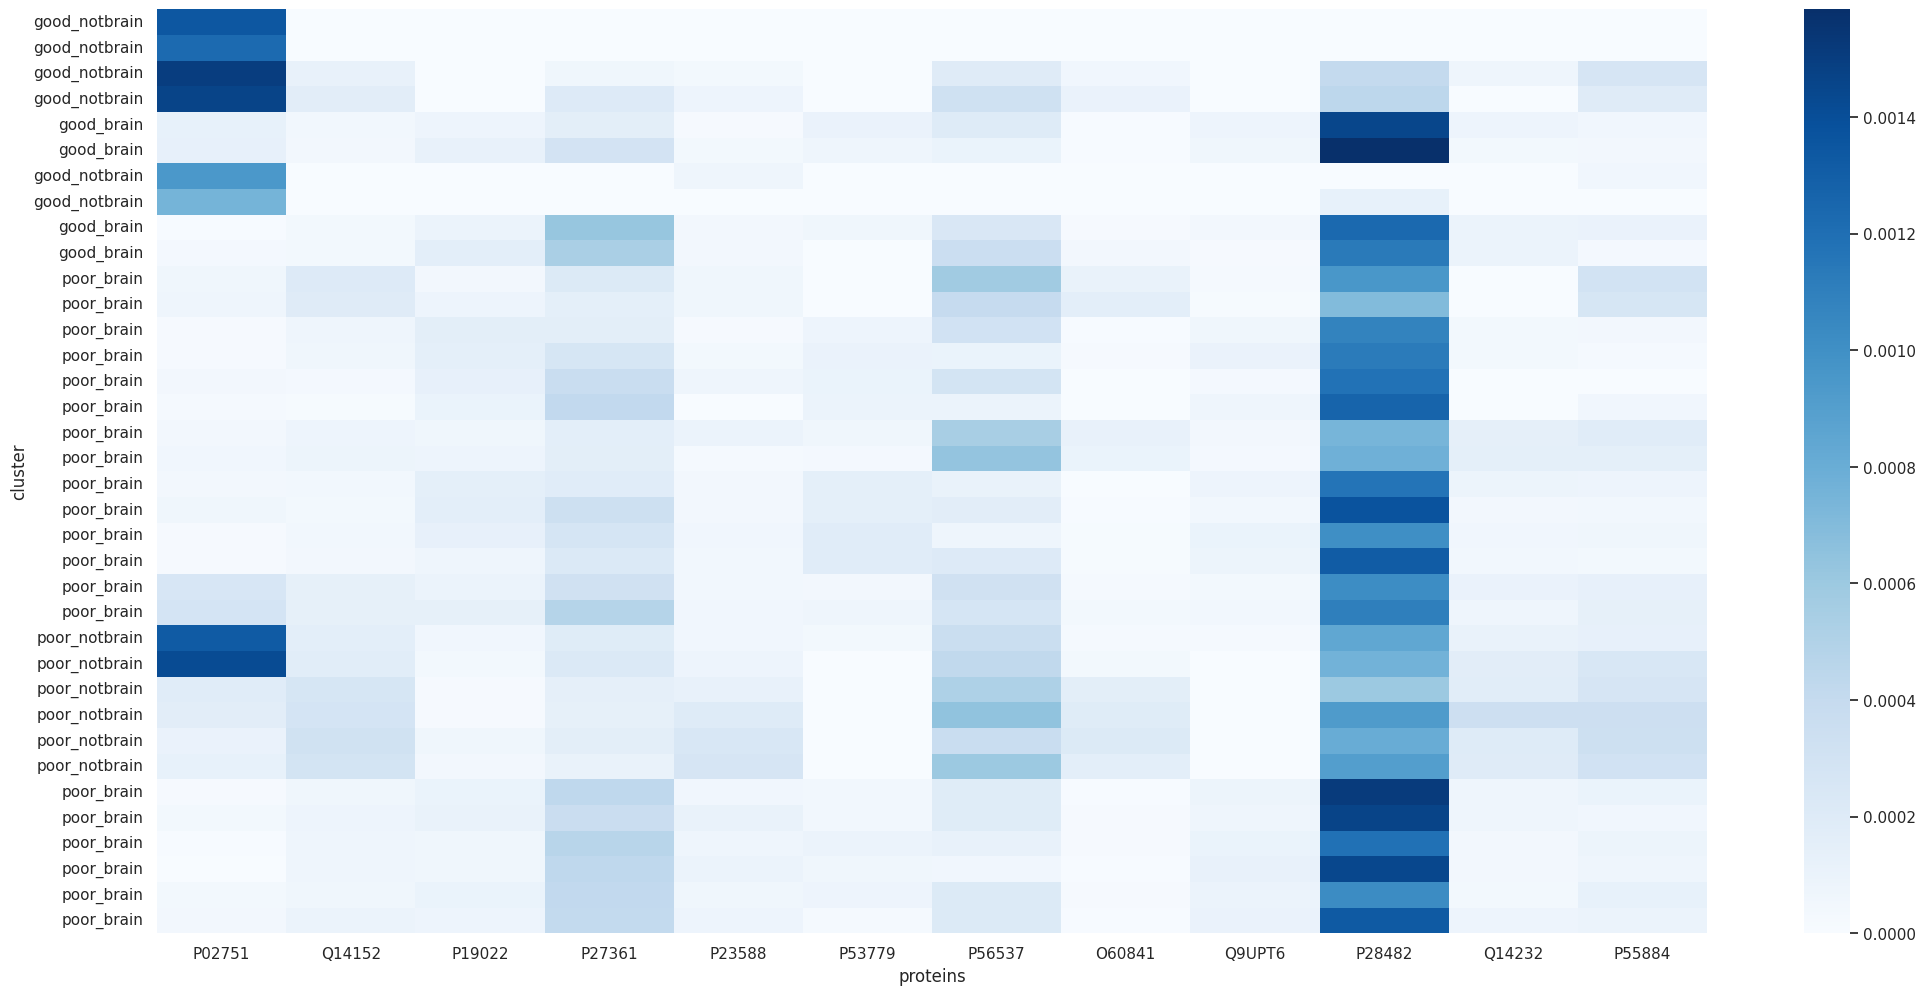

In [101]:
for proteinset  in [neuronal, ecm, mapk]:
    POIs_in_data = set(proteinset).intersection(set(nsaf_entire_df.columns))
    plt.figure(figsize=(25,12))
    sns.heatmap(nsaf_entire_df.set_index(['cluster'])[list(POIs_in_data)], cmap='Blues')

In [132]:
merged_df

,filename,cluster,Protein,SHAP Value,NSAF Value
0,good_responder_1_1.mgf.gzip,good_notbrain,P02751,-0.00007,0.001344
1,good_responder_1_2.mgf.gzip,good_notbrain,P02751,-0.00007,0.001228
2,good_responder_2_1.mgf.gzip,good_notbrain,P02751,-0.00004,0.001502
3,good_responder_2_2.mgf.gzip,good_notbrain,P02751,-0.00007,0.001462
4,good_responder_3_1.mgf.gzip,good_brain,P02751,0.00003,0.000125
...,...,...,...,...,...
247,poor_responder_7_2.mgf.gzip,poor_brain,P55884,-0.00001,0.000058
248,poor_responder_8_1.mgf.gzip,poor_brain,P55884,-0.00001,0.000090
249,poor_responder_8_2.mgf.gzip,poor_brain,P55884,-0.00001,0.000073
250,poor_responder_9_1.mgf.gzip,poor_brain,P55884,0.00000,0.000129


6 (36, 6) (36, 6) 6
neuronal


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning:

The figure layout has changed to tight



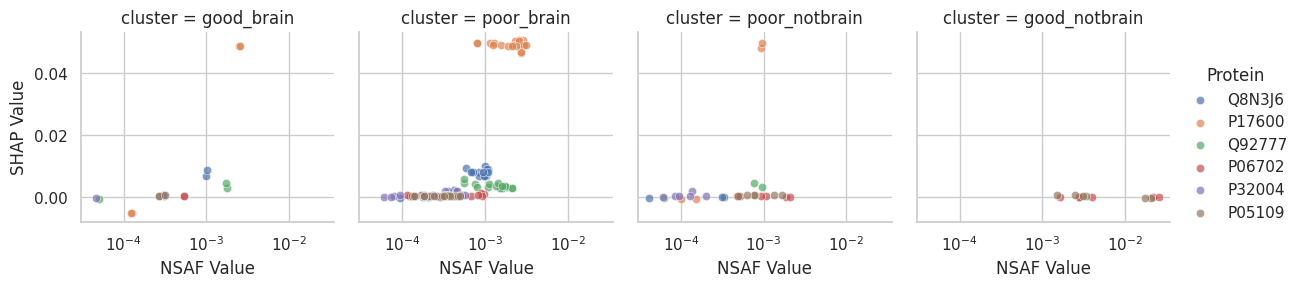

7 (36, 6) (36, 6) 6
ecm


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning:

The figure layout has changed to tight



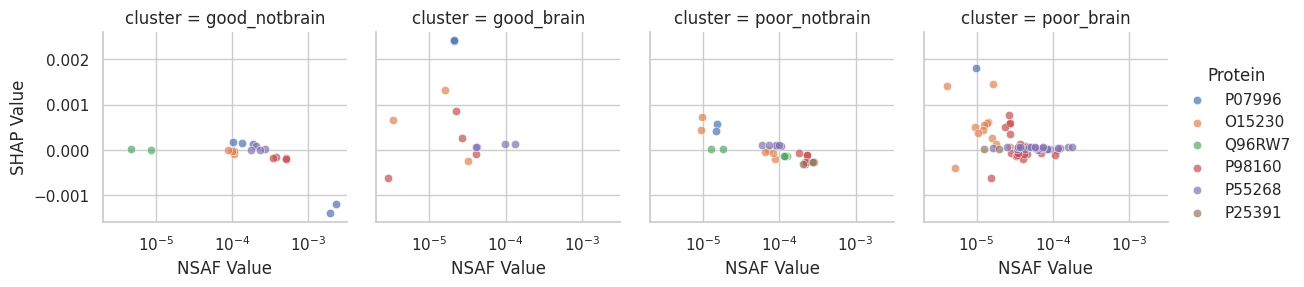

12 (36, 7) (36, 7) 7
mapk


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning:

The figure layout has changed to tight



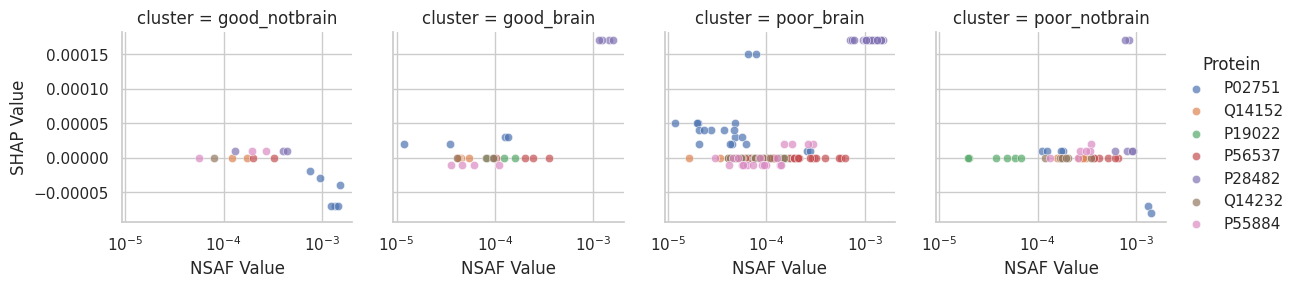

In [153]:
brain_shaps = prot_mlmarker_df_filtered[['index', 'Brain', 'filename', 'cluster']].pivot_table(columns='index', values='Brain', index= ['filename', 'cluster'])
for proteinset,setname  in zip([neuronal, ecm, mapk], ['neuronal', 'ecm', 'mapk']):
    POIs_in_nsaf = list(set(proteinset).intersection(set(brain_shaps.columns)))
    brain_subset_shaps = brain_shaps[POIs_in_nsaf]
    nsaf_subset = nsaf_entire_df.set_index(['filename', 'cluster'])[POIs_in_nsaf]
    print(len(proteinset), brain_subset_shaps.shape,nsaf_subset.shape, len(POIs_in_nsaf))
    shaps_melted = brain_subset_shaps.reset_index().melt(id_vars=['filename', 'cluster'], var_name='Protein', value_name='SHAP Value')
    nsaf_melted = nsaf_subset.reset_index().melt(id_vars=['filename', 'cluster'], var_name='Protein', value_name='NSAF Value')
    
    # Merge both datasets
    merged_df = shaps_melted.merge(nsaf_melted, on=['filename', 'cluster', 'Protein'])
    filtered_df = merged_df[merged_df["NSAF Value"] > 0]

    # Compute metadata per cluster after filtering
    cluster_summary = filtered_df.groupby("cluster").agg(
        num_proteins=("Protein", "nunique"),
        num_filenames=("filename", "nunique")
    ).reset_index()
    print(setname)
    # Define facet plot with updated titles
    g = sns.FacetGrid(filtered_df, col="cluster", hue="Protein", col_wrap=4, sharex=True, sharey=True)
    g.map_dataframe(sns.scatterplot, x="NSAF Value", y="SHAP Value", alpha=0.7)


    g.set(xscale="log")  # Log scale for better spacing

    g.add_legend()
    plt.show()

6 (36, 6) (36, 6) 6
neuronal


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning:

The figure layout has changed to tight



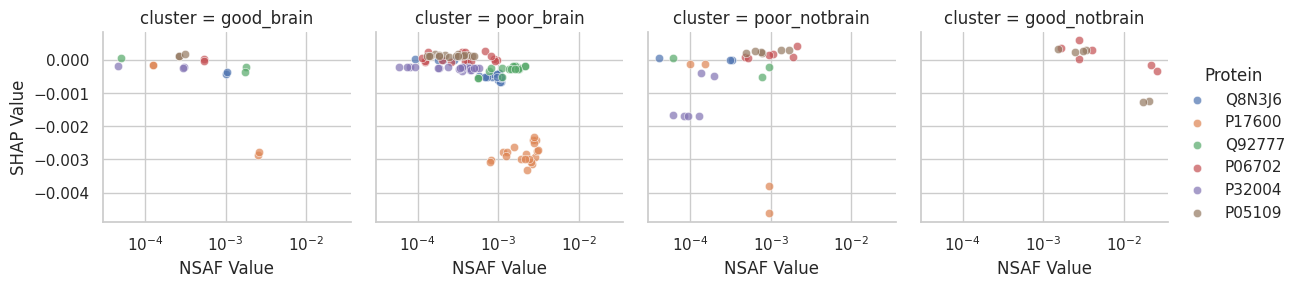

7 (36, 6) (36, 6) 6
ecm


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning:

The figure layout has changed to tight



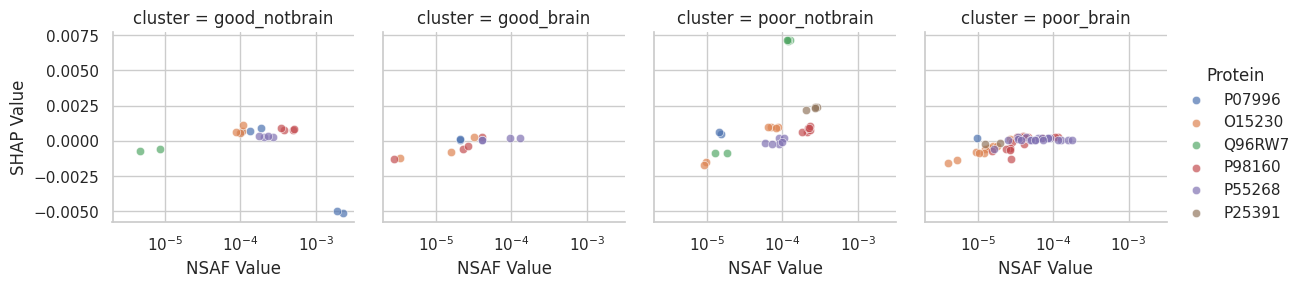

12 (36, 7) (36, 7) 7
mapk


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning:

The figure layout has changed to tight



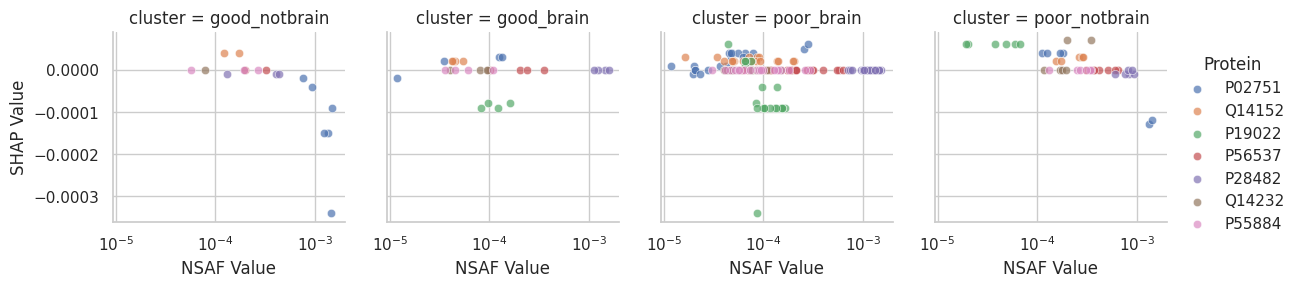

In [155]:
Lung_shaps = prot_mlmarker_df_filtered[['index', 'Lung', 'filename', 'cluster']].pivot_table(columns='index', values='Lung', index= ['filename', 'cluster'])
for proteinset,setname  in zip([neuronal, ecm, mapk], ['neuronal', 'ecm', 'mapk']):
    POIs_in_nsaf = list(set(proteinset).intersection(set(Lung_shaps.columns)))
    Lung_subset_shaps = Lung_shaps[POIs_in_nsaf]
    nsaf_subset = nsaf_entire_df.set_index(['filename', 'cluster'])[POIs_in_nsaf]
    print(len(proteinset), Lung_subset_shaps.shape,nsaf_subset.shape, len(POIs_in_nsaf))
    shaps_melted = Lung_subset_shaps.reset_index().melt(id_vars=['filename', 'cluster'], var_name='Protein', value_name='SHAP Value')
    nsaf_melted = nsaf_subset.reset_index().melt(id_vars=['filename', 'cluster'], var_name='Protein', value_name='NSAF Value')
    
    # Merge both datasets
    merged_df = shaps_melted.merge(nsaf_melted, on=['filename', 'cluster', 'Protein'])
    filtered_df = merged_df[merged_df["NSAF Value"] > 0]

    # Compute metadata per cluster after filtering
    cluster_summary = filtered_df.groupby("cluster").agg(
        num_proteins=("Protein", "nunique"),
        num_filenames=("filename", "nunique")
    ).reset_index()
    print(setname)
    # Define facet plot with updated titles
    g = sns.FacetGrid(filtered_df, col="cluster", hue="Protein", col_wrap=4, sharex=True, sharey=True)
    g.map_dataframe(sns.scatterplot, x="NSAF Value", y="SHAP Value", alpha=0.7)


    g.set(xscale="log")  # Log scale for better spacing

    g.add_legend()
    plt.show()

6 (36, 6) (36, 6) 6
neuronal


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning:

The figure layout has changed to tight



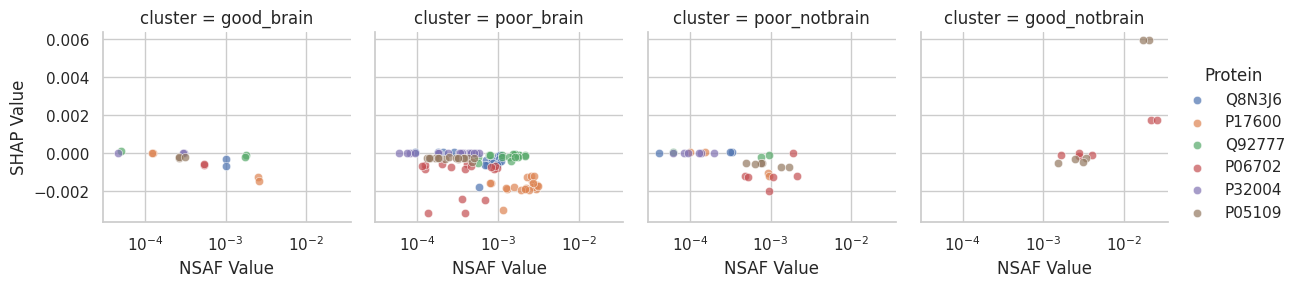

7 (36, 6) (36, 6) 6
ecm


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning:

The figure layout has changed to tight



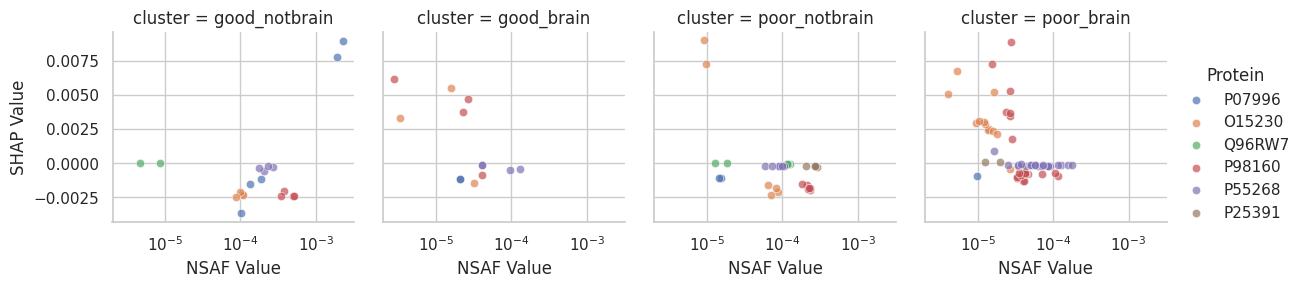

12 (36, 7) (36, 7) 7
mapk


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning:

The figure layout has changed to tight



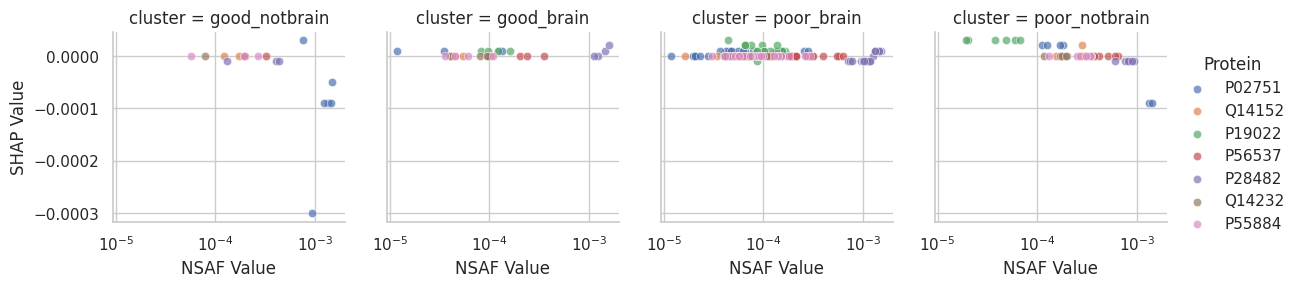

In [156]:
Monocytes_shaps = prot_mlmarker_df_filtered[['index', 'Monocytes', 'filename', 'cluster']].pivot_table(columns='index', values='Monocytes', index= ['filename', 'cluster'])
for proteinset,setname  in zip([neuronal, ecm, mapk], ['neuronal', 'ecm', 'mapk']):
    POIs_in_nsaf = list(set(proteinset).intersection(set(Monocytes_shaps.columns)))
    Monocytes_subset_shaps = Monocytes_shaps[POIs_in_nsaf]
    nsaf_subset = nsaf_entire_df.set_index(['filename', 'cluster'])[POIs_in_nsaf]
    print(len(proteinset), Monocytes_subset_shaps.shape,nsaf_subset.shape, len(POIs_in_nsaf))
    shaps_melted = Monocytes_subset_shaps.reset_index().melt(id_vars=['filename', 'cluster'], var_name='Protein', value_name='SHAP Value')
    nsaf_melted = nsaf_subset.reset_index().melt(id_vars=['filename', 'cluster'], var_name='Protein', value_name='NSAF Value')
    
    # Merge both datasets
    merged_df = shaps_melted.merge(nsaf_melted, on=['filename', 'cluster', 'Protein'])
    filtered_df = merged_df[merged_df["NSAF Value"] > 0]

    # Compute metadata per cluster after filtering
    cluster_summary = filtered_df.groupby("cluster").agg(
        num_proteins=("Protein", "nunique"),
        num_filenames=("filename", "nunique")
    ).reset_index()
    print(setname)
    # Define facet plot with updated titles
    g = sns.FacetGrid(filtered_df, col="cluster", hue="Protein", col_wrap=4, sharex=True, sharey=True)
    g.map_dataframe(sns.scatterplot, x="NSAF Value", y="SHAP Value", alpha=0.7)


    g.set(xscale="log")  # Log scale for better spacing

    g.add_legend()
    plt.show()

In [157]:
upregulated_poor = ["Q14232",
"Q14152",
"P55884",
"O00303",
"O75821",
"Q13347",
"Q9UBQ5",
"Q9Y262",
"P23588",
"Q15056",
"O60841",
"Q8N111",
"P51674",
"P62166",
"Q7Z3B1",
"Q15818",
"Q92823",
"Q9UH03",
"P17600",
"Q92777",
"O14994",
"P30531",
"P43003",
"P43004",
"P43007",
"P48066",
"Q15043",
"Q6PML9",
"Q8N4V1",
"Q8TBB6",
"Q96QE2",
"Q99726",
"Q9H1V8",
"Q9NS82",
"P32418",
"Q8TCU6",
"Q92581",
"Q9UPR5",
"Q15904",
"Q93050",
"P27449",
"P61421",
"P38606",
"P21281",
"P21283",
"Q9Y5K8",
"P36543",
"Q16864",
"O75348",
"O95670",
"Q9UI12",
"P28482",
"P53779",
"P27361",
"Q9UPT6",
"O00533",
"O15394",
"P13591",
"P32004",
"Q14982",
"Q14CZ8",
"Q8N3J6",
"Q8NFZ8",
"Q92823",
"P62158",
"Q14012",
"Q9UQM7",
"Q13554",
"Q13555",
"Q16566",
"Q8N5S9",
"Q96RR4",
"Q9P1Y5",
"P54750",
"Q01064",
"P19022"]
upregulated_good = [
"P05164",
"P01909",
"P04233",
"P20039",
"Q95365",
"Q5Y7A7",
"P01594",
"P01609",
"P01613",
"P01617",
"P01623",
"P01777",
"P01767",
"P01779",
"P01834",
"P01857",
"P01860",
"P01871",
"P01876",
"P01880",
"O14791",
"P02647",
"P04114",
"P06727",
"P16284",
"P31997",
"P40199",
"P02452",
"P02751",
"P08123",
"P25067",
"P39059",
"Q05707",
"Q96P44"]

34 (36, 12) (36, 12) 12
good


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning:

The figure layout has changed to tight



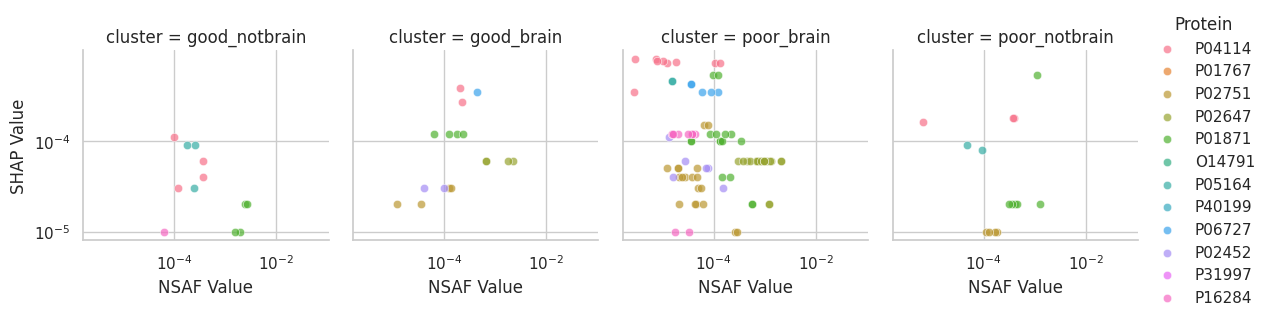

76 (36, 39) (36, 39) 39
poor


/home/compomics/miniconda3/envs/mlmarker/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning:

The figure layout has changed to tight



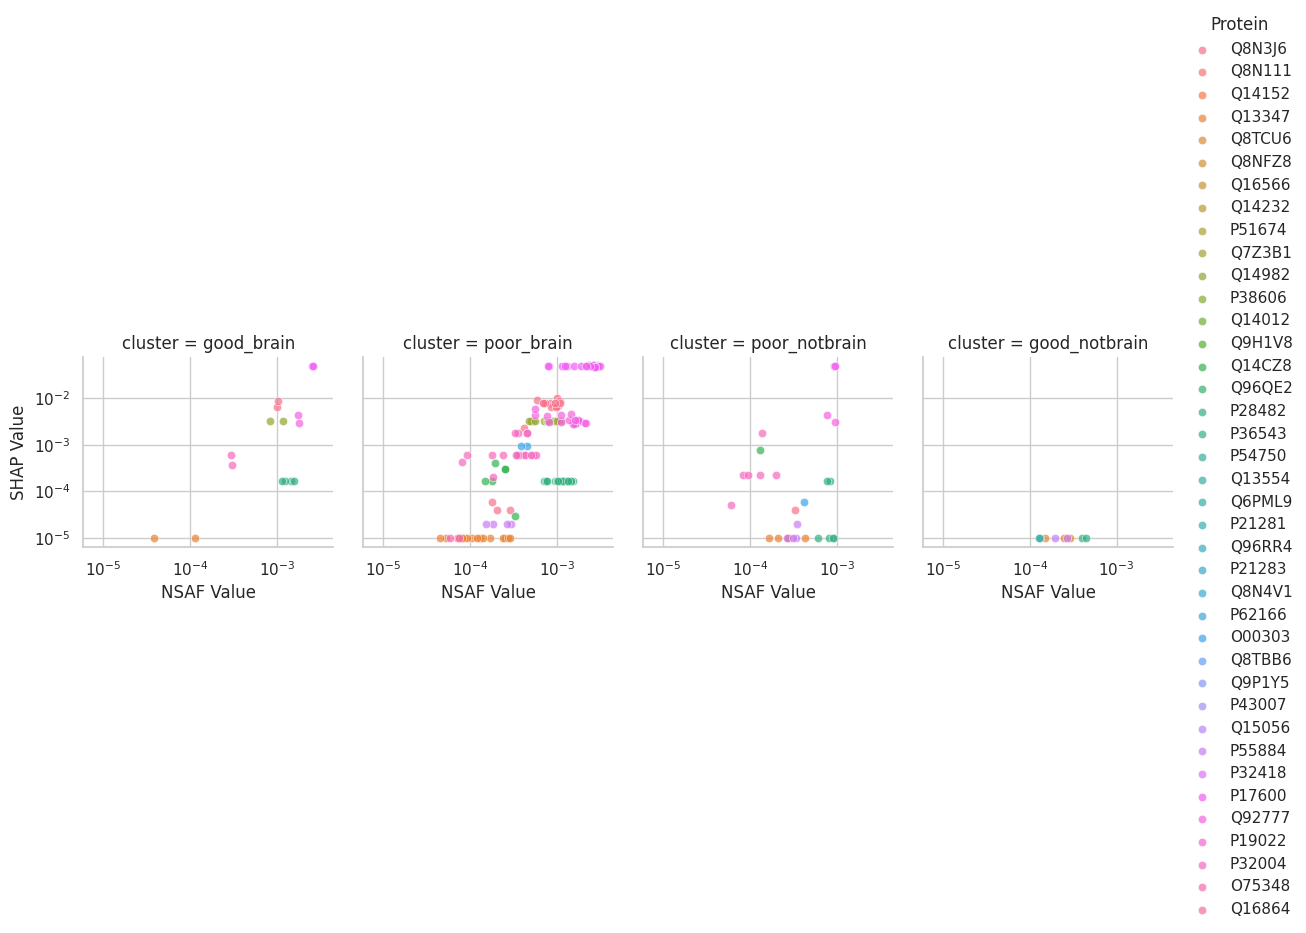

In [159]:
Brain_shaps = prot_mlmarker_df_filtered[['index', 'Brain', 'filename', 'cluster']].pivot_table(columns='index', values='Brain', index= ['filename', 'cluster'])
for proteinset,setname  in zip([upregulated_good, upregulated_poor], ['good', 'poor']):
    POIs_in_nsaf = list(set(proteinset).intersection(set(Brain_shaps.columns)))
    Brain_subset_shaps = Brain_shaps[POIs_in_nsaf]
    nsaf_subset = nsaf_entire_df.set_index(['filename', 'cluster'])[POIs_in_nsaf]
    print(len(proteinset), Brain_subset_shaps.shape,nsaf_subset.shape, len(POIs_in_nsaf))
    shaps_melted = Brain_subset_shaps.reset_index().melt(id_vars=['filename', 'cluster'], var_name='Protein', value_name='SHAP Value')
    nsaf_melted = nsaf_subset.reset_index().melt(id_vars=['filename', 'cluster'], var_name='Protein', value_name='NSAF Value')
    
    # Merge both datasets
    merged_df = shaps_melted.merge(nsaf_melted, on=['filename', 'cluster', 'Protein'])
    filtered_df = merged_df[merged_df["NSAF Value"] > 0]

    # Compute metadata per cluster after filtering
    cluster_summary = filtered_df.groupby("cluster").agg(
        num_proteins=("Protein", "nunique"),
        num_filenames=("filename", "nunique")
    ).reset_index()
    print(setname)
    # Define facet plot with updated titles
    g = sns.FacetGrid(filtered_df, col="cluster", hue="Protein", col_wrap=4, sharex=True, sharey=True)
    g.map_dataframe(sns.scatterplot, x="NSAF Value", y="SHAP Value", alpha=0.7)


    g.set(xscale="log")  # Log scale for better spacing
    g.set(yscale='log')
    g.add_legend()
    plt.show()